# Imports and variable setup

In [1]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import plotly.express as px
import pandas as pd
import numpy as np
import os

import datetime 

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils import filter_by_rule, detect_outliers_z_score, report_results, run_dbscan, \
    get_kdist_plot, dbscan_predict, calculate_adjusted_density, evaluate_classifier, \
    get_distance, remove_outliers_and_normalize, evaluate_clustering
from config import *
import pickle


import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning, FutureWarning, UserWarning))

from DSClassifierMultiQ import DSClassifierMultiQ

import pickle

c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import logging


if not os.path.exists("logs"):
    os.mkdir("logs")

log_file = os.path.join("logs", "api_new.log")

rfh = logging.handlers.RotatingFileHandler(
    filename=log_file,
    mode='a',
    maxBytes=LOGGING_MAX_SIZE_MB*1024*1024,
    backupCount=LOGGING_BACKUP_COUNT,
    encoding=None,
    delay=0
)

logging.getLogger('matplotlib.font_manager').disabled = True

console_handler = logging.StreamHandler()

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%y-%m-%d %H:%M:%S",
    handlers=[
        rfh,
        console_handler
    ],
)

logger = logging.getLogger(__name__)

In [4]:
#  https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor/data
DATASET_FOLDER = "datasets" 

assert os.path.exists(DATASET_FOLDER), "Dataset folder not found"

datasets = os.listdir(DATASET_FOLDER)
logging.info(f"Found {len(datasets)} datasets")

24-04-29 01:25:29 [INFO] Found 6 datasets


# All in one cell

In [8]:
def do_all_for_dataset(dataset, nrows=None, ratio_deviation=0.1, label_col_for_dist=LABEL_COL_FOR_DIST, 
                       CLUSTERING_ALG="kmeans"):
    dataset_name = dataset.split(".")[0]
    if nrows:
        data = pd.read_csv(os.path.join(DATASET_FOLDER, dataset)).sample(nrows)
    else:
        data = pd.read_csv(os.path.join(DATASET_FOLDER, dataset))    

    logger.debug(f"Dataset: {dataset_name} | Shape: {data.shape}")
    # if missing more than 20% of the data, drop the column
    missing_threshold = 0.2
    data = data.dropna(thresh=len(data) * (1 - missing_threshold), axis=1)
    logger.debug(f"{data.shape} droped columns with more than {missing_threshold*100:.0f}% missing values")
    # drop rows with missing values
    data = data.dropna()
    logger.debug(f"{data.shape} drop rows with missing values")

    assert data.isna().sum().sum() == 0, "Dataset contains missing values"
    assert "labels" in data.columns, "Dataset does not contain `labels` column"
    assert data.labels.nunique() == 2, f"Dataset labels are not binary ({data.labels.unique()})"

    label_ratio = data.labels.value_counts(normalize=True).iloc[0]
    assert abs(label_ratio -0.5) < ratio_deviation, f"Label ratio is not balanced ({label_ratio})"

    # leave only numeric columns
    data = data.select_dtypes(include=[np.number])
    logger.debug(f"{data.shape} drop non-numeric columns")

    # move labels column to the end 
    data = data[[col for col in data.columns if col != "labels"] + ["labels"]]

    logging.info(f"------ Dataset: {dataset_name} | Shape: {data.shape} | Label ratio: {label_ratio:.2f} -------")

    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    data = data.apply(pd.to_numeric)
    cut = int(train_set_size*len(data))

    train_data_df = data.iloc[:cut]
    test_data_df = data.iloc[cut:]

    X_train = data.iloc[:cut, :-1].values
    y_train = data.iloc[:cut, -1].values
    X_test = data.iloc[cut:, :-1].values
    y_test = data.iloc[cut:, -1].values

    logging.info(f"Step 0: Data split done | {len(X_train)} - {len(X_test)}")


    st_scaler = StandardScaler().fit(train_data_df)
    # break
    scale = st_scaler.scale_
    mean = st_scaler.mean_
    var = st_scaler.var_ 

    X_train_scaled = st_scaler.transform(train_data_df)
    X_test_scaled = st_scaler.transform(test_data_df)  #! during inference we won't have this

    logging.debug("Step 1: Standard scaling complete")
    logging.info(f"Step 2.1: Performing {CLUSTERING_ALG} clustering")


    db_eps = None # if DBSCAN then will get overriden
    if CLUSTERING_ALG == "kmeans":
        clustering_model = KMeans(n_clusters=2, random_state=42, n_init="auto")      
        clustering_model.fit(X_train_scaled)  
        
        clustering_labels_train = clustering_model.predict(X_train_scaled)
        clustering_labels_test = clustering_model.predict(X_test_scaled)
    else:
        clustering_model = run_dbscan(X_train_scaled, eps=0.01, max_eps=20, min_samples=2*X_train_scaled.shape[1]-1, step=0.05) #*X_train.shape[1] - 1)
        if clustering_model is None:
            logging.warning(f"Could not find the desired number of clusters for {dataset_name}")
            raise Exception("Clustering failed")
        
        clustering_labels_train = dbscan_predict(clustering_model, X_train_scaled)
        clustering_labels_test = dbscan_predict(clustering_model, X_test_scaled)
        
        db_eps = clustering_model.eps
        


    train_data_df["labels_clustering"] = clustering_labels_train
    test_data_df["labels_clustering"] = clustering_labels_test

    logger.info(f"Step 2.1: Clustering and inference done")
        
    evaluate_clustering(X_train_scaled, clustering_labels_train, clustering_model, 
                        CLUSTERING_ALG, print_results=True)
    evaluate_clustering(X_test_scaled, clustering_labels_test, clustering_model, 
                        CLUSTERING_ALG, print_results=True, dataset="test")

    logging.info("Step 2.2: Clustering evaluation done")

    evaluate_classifier(y_actual=y_train, y_clust=clustering_labels_train, 
                        dataset="train", print_results=True)
    evaluate_classifier(y_actual=y_test, y_clust=clustering_labels_test, 
                        dataset="test", print_results=True)

    logger.info("Step 3: Clustering as a classifier, evaluation done")

    train_data_df["distance"] = get_distance(X_train_scaled, clustering_model, CLUSTERING_ALG, density_radius=db_eps)
    test_data_df["distance"] = get_distance(X_test_scaled, clustering_model, CLUSTERING_ALG, density_radius=db_eps)

    train_data_df["distance_norm"] = remove_outliers_and_normalize(train_data_df, label_column="labels_clustering") 
    test_data_df["distance_norm"] = remove_outliers_and_normalize(test_data_df, label_column="labels_clustering")
    
    assert train_data_df.isna().sum().sum() == 0, "Train data contains NaNs"
    assert test_data_df.isna().sum().sum() == 0, "Train data contains NaNs"

    logger.info(f"Step 4: Distance calculation done")

    num_breaks = 3
    mult_rules = False
    debug_mode = True
    print_final_model = True
    num_workers = 0

    RULE_FOLDER = "rules_saved_clean"

    ignore_for_training = ["labels_clustering", "distance_norm"]
    df_cols = [i for i in list(data.columns) if i not in ignore_for_training]

    rows_use = None
    if rows_use:
        train_data_df_use = train_data_df.head(rows_use)
        X_train_use = X_train[:rows_use]
        y_train_use = y_train[:rows_use]
    else:
        train_data_df_use = train_data_df
        X_train_use = X_train
        y_train_use = y_train
    logger.debug(f"Train: {len(X_train_use)}")
    for method in ["clustering", "random"]:
        name = f"dataset={dataset_name}, label_for_dist={LABEL_COL_FOR_DIST}, clust={CLUSTERING_ALG}, breaks={num_breaks}, add_mult_rules={mult_rules}, maf_method={method}"
        logger.info(f"Step 5: Run DST ({name})")
        DSC = DSClassifierMultiQ(2, debug_mode=debug_mode, num_workers=num_workers, maf_method=method,
                                data=train_data_df_use, precompute_rules=True, )#.head(rows_use))
        logger.debug(f"\tModel init done")    
        res = DSC.fit(X_train_use, y_train_use, 
                add_single_rules=True, single_rules_breaks=num_breaks, add_mult_rules=mult_rules,
                column_names=df_cols, print_every_epochs=1, print_final_model=print_final_model)
        losses, epoch, dt = res
        logger.debug(f"\tModel fit done")

        DSC.model.save_rules_bin(os.path.join(RULE_FOLDER, f"{name}.dsb"))
    #     most_important_rules = DSC.model.find_most_important_rules()
    #     print(most_important_rules)
        DSC.model.print_most_important_rules()
        y_pred = DSC.predict(X_test)

        logger.info(f"Step 6: Inference done")

        report_results(y_test, y_pred, dataset=dataset_name, method=method,
                    epoch=epoch, dt=dt, losses=losses, 
                    save_results=True, name=name, print_results=True,
                    breaks=num_breaks, mult_rules=mult_rules, clustering_alg=CLUSTERING_ALG, label_for_dist=LABEL_COL_FOR_DIST)
        logging.info("-"*30)
        
        

In [9]:
datasets

['Brain Tumor.csv',
 'breast-cancer-wisconsin.csv',
 'gaussian_df.csv',
 'rectangle_df.csv',
 'uniform_df.csv',
 'wine.csv']

  0%|          | 0/6 [00:00<?, ?it/s]24-04-29 01:27:14 [DEBUG] Dataset: Brain Tumor | Shape: (3762, 14)
24-04-29 01:27:14 [DEBUG] (3762, 14) droped columns with more than 20% missing values
24-04-29 01:27:14 [DEBUG] (3762, 14) drop rows with missing values
24-04-29 01:27:14 [DEBUG] (3762, 14) drop non-numeric columns
24-04-29 01:27:14 [INFO] ------ Dataset: Brain Tumor | Shape: (3762, 14) | Label ratio: 0.55 -------
24-04-29 01:27:14 [INFO] Step 0: Data split done | 2633 - 1129
24-04-29 01:27:14 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:27:14 [INFO] Step 2.1: Performing kmeans clustering
Exception in thread Thread-25 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\hayk_\.conda\envs\thesis\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\hayk_\.conda\envs\thesis\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\hayk_\.conda\envs\thesis\lib\subprocess.py", line 1515, in _rea

Optimization started
Processing epoch	117	0.0178	

24-04-29 01:29:36 [DEBUG] 	Model fit done



Training time: 138.47s, epochs: 117

Least training loss reached: 0.018
DSModelMultiQ(
  DS Classifier using 49 rules
  
  Rule 1: Mean < 5.660
  	C1: 0.065	C2: 0.750	Unc: 0.185
  
  Rule 2: 5.660 < Mean < 9.563
  	C1: 0.428	C2: 0.293	Unc: 0.279
  
  Rule 3: 9.563 < Mean < 13.466
  	C1: 0.487	C2: 0.256	Unc: 0.257
  
  Rule 4: Mean > 13.466
  	C1: 0.662	C2: 0.162	Unc: 0.176
  
  Rule 5: Variance < 396.340
  	C1: 0.556	C2: 0.201	Unc: 0.243
  
  Rule 6: 396.340 < Variance < 708.627
  	C1: 0.450	C2: 0.274	Unc: 0.276
  
  Rule 7: 708.627 < Variance < 1020.914
  	C1: 0.448	C2: 0.281	Unc: 0.271
  
  Rule 8: Variance > 1020.914
  	C1: 0.132	C2: 0.654	Unc: 0.213
  
  Rule 9: Standard Deviation < 19.243
  	C1: 0.530	C2: 0.217	Unc: 0.254
  
  Rule 10: 19.243 < Standard Deviation < 25.142
  	C1: 0.477	C2: 0.261	Unc: 0.263
  
  Rule 11: 25.142 < Standard Deviation < 31.042
  	C1: 0.420	C2: 0.295	Unc: 0.285
  
  Rule 12: Standard Deviation > 31.042
  	C1: 0.107	C2: 0.689	Unc: 0.203
  
  Rule 13: En

24-04-29 01:29:36 [INFO] Step 6: Inference done
24-04-29 01:29:36 [DEBUG] Training Time: 138.47s
24-04-29 01:29:36 [DEBUG] Epochs: 117
24-04-29 01:29:36 [DEBUG] Min Loss: 0.018
24-04-29 01:29:36 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
24-04-29 01:29:36 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.


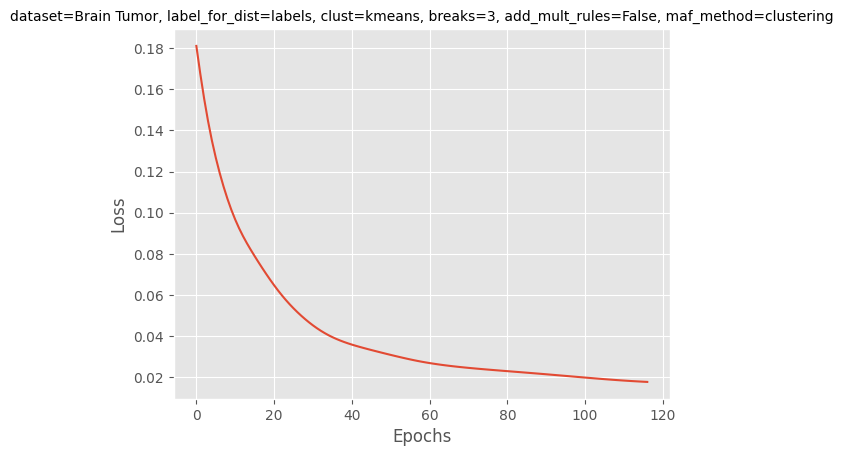

24-04-29 01:29:37 [DEBUG] Accuracy:  0.98
24-04-29 01:29:37 [DEBUG] F1 Score: 0.98
24-04-29 01:29:37 [DEBUG] Confusion Matrix: 
[[606   5]
 [ 16 502]]
24-04-29 01:29:37 [INFO] ------------------------------
24-04-29 01:29:37 [INFO] Step 5: Run DST (dataset=Brain Tumor, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:29:37 [DEBUG] 	Model init done


Optimization started
Processing epoch	132	0.0261	

24-04-29 01:32:14 [DEBUG] 	Model fit done



Training time: 157.08s, epochs: 132

Least training loss reached: 0.026
DSModelMultiQ(
  DS Classifier using 49 rules
  
  Rule 1: Mean < 5.660
  	C1: 0.000	C2: 0.316	Unc: 0.684
  
  Rule 2: 5.660 < Mean < 9.563
  	C1: 0.000	C2: 0.212	Unc: 0.788
  
  Rule 3: 9.563 < Mean < 13.466
  	C1: 0.175	C2: 0.017	Unc: 0.808
  
  Rule 4: Mean > 13.466
  	C1: 0.378	C2: 0.000	Unc: 0.622
  
  Rule 5: Variance < 396.340
  	C1: 0.237	C2: 0.000	Unc: 0.763
  
  Rule 6: 396.340 < Variance < 708.627
  	C1: 0.198	C2: 0.000	Unc: 0.802
  
  Rule 7: 708.627 < Variance < 1020.914
  	C1: 0.058	C2: 0.114	Unc: 0.827
  
  Rule 8: Variance > 1020.914
  	C1: 0.000	C2: 0.320	Unc: 0.680
  
  Rule 9: Standard Deviation < 19.243
  	C1: 0.258	C2: 0.000	Unc: 0.742
  
  Rule 10: 19.243 < Standard Deviation < 25.142
  	C1: 0.151	C2: 0.028	Unc: 0.821
  
  Rule 11: 25.142 < Standard Deviation < 31.042
  	C1: 0.070	C2: 0.111	Unc: 0.818
  
  Rule 12: Standard Deviation > 31.042
  	C1: 0.000	C2: 0.350	Unc: 0.650
  
  Rule 13: En

24-04-29 01:32:14 [INFO] Step 6: Inference done
24-04-29 01:32:14 [DEBUG] Training Time: 157.08s
24-04-29 01:32:14 [DEBUG] Epochs: 132
24-04-29 01:32:14 [DEBUG] Min Loss: 0.026


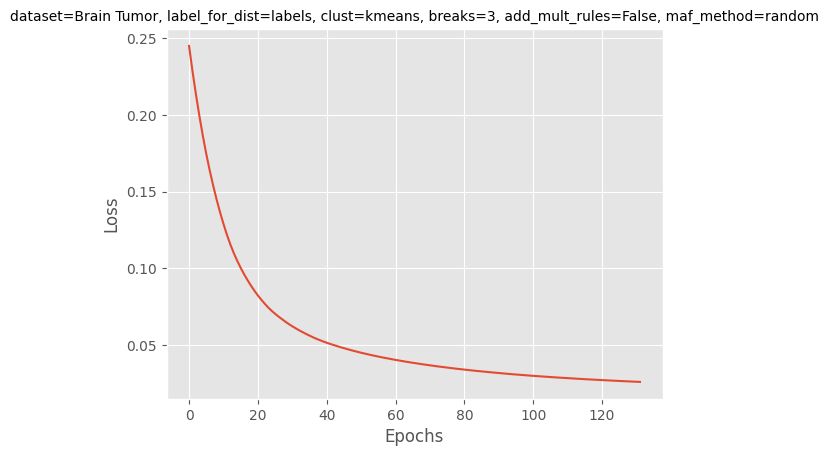

24-04-29 01:32:15 [DEBUG] Accuracy:  0.98
24-04-29 01:32:15 [DEBUG] F1 Score: 0.98
24-04-29 01:32:15 [DEBUG] Confusion Matrix: 
[[610   1]
 [ 18 500]]
24-04-29 01:32:15 [INFO] ------------------------------
24-04-29 01:32:15 [DEBUG] Dataset: Brain Tumor | Shape: (3762, 14)
24-04-29 01:32:15 [DEBUG] (3762, 14) droped columns with more than 20% missing values
24-04-29 01:32:15 [DEBUG] (3762, 14) drop rows with missing values
24-04-29 01:32:15 [DEBUG] (3762, 14) drop non-numeric columns
24-04-29 01:32:15 [INFO] ------ Dataset: Brain Tumor | Shape: (3762, 14) | Label ratio: 0.55 -------
24-04-29 01:32:15 [INFO] Step 0: Data split done | 2633 - 1129
24-04-29 01:32:15 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:32:15 [INFO] Step 2.1: Performing dbscan clustering
24-04-29 01:32:16 [INFO] Step 2.1: Clustering and inference done


Found the desired number of clusters: 2 at eps=0.8100000000000003


24-04-29 01:32:16 [DEBUG] Evaluation on train
24-04-29 01:32:16 [DEBUG] 	silhouette = 0.088
24-04-29 01:32:16 [DEBUG] 	calinski_harabasz = 379.206
24-04-29 01:32:16 [DEBUG] Evaluation on test
24-04-29 01:32:16 [DEBUG] 	silhouette = 0.065
24-04-29 01:32:16 [DEBUG] 	calinski_harabasz = 137.358
24-04-29 01:32:16 [INFO] Step 2.2: Clustering evaluation done
24-04-29 01:32:16 [DEBUG] Evaluation on train
24-04-29 01:32:16 [DEBUG] 	Accuracy:  0.50
24-04-29 01:32:16 [DEBUG] 	F1 Score: 1.00
24-04-29 01:32:16 [DEBUG] 	Confusion Matrix: 
[[1065    0]
 [   0  263]]
24-04-29 01:32:16 [DEBUG] Evaluation on test
24-04-29 01:32:16 [DEBUG] 	Accuracy:  0.16
24-04-29 01:32:16 [DEBUG] 	F1 Score: 0.00
24-04-29 01:32:16 [DEBUG] 	Confusion Matrix: 
[[181 430]
 [518   0]]
24-04-29 01:32:16 [INFO] Step 3: Clustering as a classifier, evaluation done
24-04-29 01:32:17 [INFO] Step 4: Distance calculation done
24-04-29 01:32:17 [DEBUG] Train: 2633
24-04-29 01:32:17 [INFO] Step 5: Run DST (dataset=Brain Tumor, label

Optimization started
Processing epoch	53	0.0193	

24-04-29 01:33:19 [DEBUG] 	Model fit done



Training time: 57.86s, epochs: 53

Least training loss reached: 0.019
DSModelMultiQ(
  DS Classifier using 49 rules
  
  Rule 1: Mean < 5.660
  	C1: 0.145	C2: 0.709	Unc: 0.146
  
  Rule 2: 5.660 < Mean < 9.563
  	C1: 0.426	C2: 0.299	Unc: 0.275
  
  Rule 3: 9.563 < Mean < 13.466
  	C1: 0.458	C2: 0.264	Unc: 0.278
  
  Rule 4: Mean > 13.466
  	C1: 0.830	C2: 0.000	Unc: 0.170
  
  Rule 5: Variance < 396.340
  	C1: 0.780	C2: 0.062	Unc: 0.159
  
  Rule 6: 396.340 < Variance < 708.627
  	C1: 0.511	C2: 0.232	Unc: 0.257
  
  Rule 7: 708.627 < Variance < 1020.914
  	C1: 0.533	C2: 0.234	Unc: 0.233
  
  Rule 8: Variance > 1020.914
  	C1: 0.230	C2: 0.555	Unc: 0.215
  
  Rule 9: Standard Deviation < 19.243
  	C1: 0.785	C2: 0.059	Unc: 0.156
  
  Rule 10: 19.243 < Standard Deviation < 25.142
  	C1: 0.594	C2: 0.160	Unc: 0.245
  
  Rule 11: 25.142 < Standard Deviation < 31.042
  	C1: 0.450	C2: 0.276	Unc: 0.274
  
  Rule 12: Standard Deviation > 31.042
  	C1: 0.238	C2: 0.541	Unc: 0.221
  
  Rule 13: Entr

24-04-29 01:33:19 [INFO] Step 6: Inference done
24-04-29 01:33:19 [DEBUG] Training Time: 57.86s
24-04-29 01:33:19 [DEBUG] Epochs: 53
24-04-29 01:33:19 [DEBUG] Min Loss: 0.019


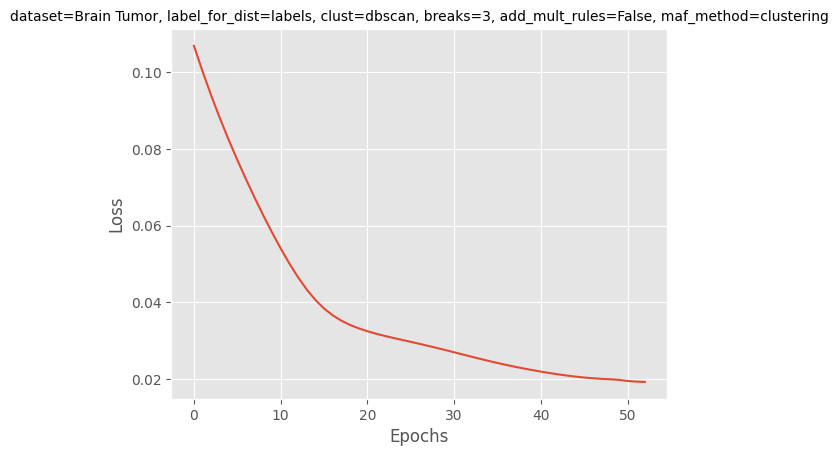

24-04-29 01:33:19 [DEBUG] Accuracy:  0.98
24-04-29 01:33:19 [DEBUG] F1 Score: 0.97
24-04-29 01:33:19 [DEBUG] Confusion Matrix: 
[[604   7]
 [ 19 499]]
24-04-29 01:33:19 [INFO] ------------------------------
24-04-29 01:33:19 [INFO] Step 5: Run DST (dataset=Brain Tumor, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:33:19 [DEBUG] 	Model init done


Optimization started
Processing epoch	140	0.0267	

24-04-29 01:36:56 [DEBUG] 	Model fit done



Training time: 216.23s, epochs: 140

Least training loss reached: 0.027
DSModelMultiQ(
  DS Classifier using 49 rules
  
  Rule 1: Mean < 5.660
  	C1: 0.000	C2: 0.314	Unc: 0.686
  
  Rule 2: 5.660 < Mean < 9.563
  	C1: 0.000	C2: 0.176	Unc: 0.824
  
  Rule 3: 9.563 < Mean < 13.466
  	C1: 0.170	C2: 0.022	Unc: 0.808
  
  Rule 4: Mean > 13.466
  	C1: 0.299	C2: 0.000	Unc: 0.701
  
  Rule 5: Variance < 396.340
  	C1: 0.212	C2: 0.000	Unc: 0.788
  
  Rule 6: 396.340 < Variance < 708.627
  	C1: 0.231	C2: 0.000	Unc: 0.769
  
  Rule 7: 708.627 < Variance < 1020.914
  	C1: 0.110	C2: 0.076	Unc: 0.814
  
  Rule 8: Variance > 1020.914
  	C1: 0.000	C2: 0.224	Unc: 0.776
  
  Rule 9: Standard Deviation < 19.243
  	C1: 0.359	C2: 0.000	Unc: 0.641
  
  Rule 10: 19.243 < Standard Deviation < 25.142
  	C1: 0.228	C2: 0.000	Unc: 0.772
  
  Rule 11: 25.142 < Standard Deviation < 31.042
  	C1: 0.124	C2: 0.062	Unc: 0.814
  
  Rule 12: Standard Deviation > 31.042
  	C1: 0.000	C2: 0.214	Unc: 0.786
  
  Rule 13: En

24-04-29 01:36:56 [INFO] Step 6: Inference done
24-04-29 01:36:56 [DEBUG] Training Time: 216.23s
24-04-29 01:36:56 [DEBUG] Epochs: 140
24-04-29 01:36:56 [DEBUG] Min Loss: 0.027


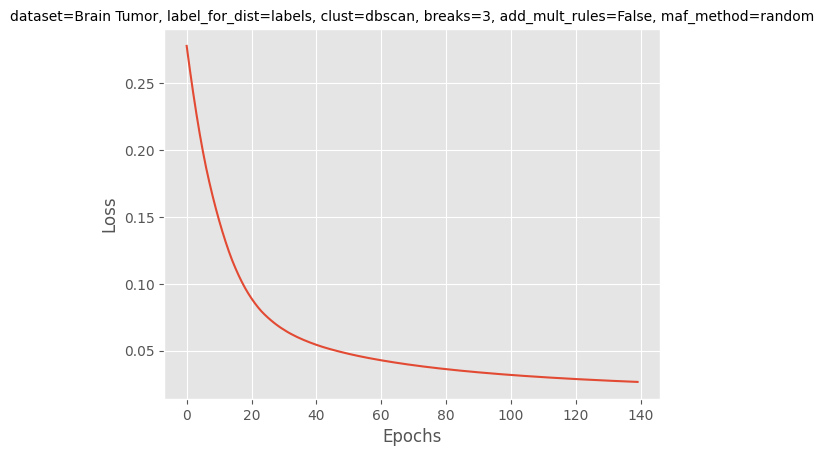

24-04-29 01:36:56 [DEBUG] Accuracy:  0.98
24-04-29 01:36:56 [DEBUG] F1 Score: 0.98
24-04-29 01:36:56 [DEBUG] Confusion Matrix: 
[[610   1]
 [ 18 500]]
24-04-29 01:36:56 [INFO] ------------------------------
 17%|█▋        | 1/6 [09:42<48:34, 582.84s/it]24-04-29 01:36:56 [DEBUG] Dataset: breast-cancer-wisconsin | Shape: (683, 10)
24-04-29 01:36:56 [DEBUG] (683, 10) droped columns with more than 20% missing values
24-04-29 01:36:56 [DEBUG] (683, 10) drop rows with missing values
24-04-29 01:36:56 [DEBUG] (683, 10) drop non-numeric columns
24-04-29 01:36:56 [INFO] ------ Dataset: breast-cancer-wisconsin | Shape: (683, 10) | Label ratio: 0.65 -------
24-04-29 01:36:56 [INFO] Step 0: Data split done | 478 - 205
24-04-29 01:36:56 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:36:56 [INFO] Step 2.1: Performing kmeans clustering
24-04-29 01:36:56 [INFO] Step 2.1: Clustering and inference done
24-04-29 01:36:56 [DEBUG] Evaluation on train
24-04-29 01:36:56 [DEBUG] 	silhouette = 0.585
24-

Optimization started
Processing epoch	73	0.0228	

24-04-29 01:37:15 [DEBUG] 	Model fit done
24-04-29 01:37:15 [INFO] Step 6: Inference done
24-04-29 01:37:15 [DEBUG] Training Time: 17.24s
24-04-29 01:37:15 [DEBUG] Epochs: 73
24-04-29 01:37:15 [DEBUG] Min Loss: 0.023



Training time: 17.24s, epochs: 73

Least training loss reached: 0.023
DSModelMultiQ(
  DS Classifier using 36 rules
  
  Rule 1: clump_thickness < 2.569
  	C1: 0.725	C2: 0.112	Unc: 0.163
  
  Rule 2: 2.569 < clump_thickness < 4.454
  	C1: 0.639	C2: 0.184	Unc: 0.178
  
  Rule 3: 4.454 < clump_thickness < 6.339
  	C1: 0.568	C2: 0.222	Unc: 0.210
  
  Rule 4: clump_thickness > 6.339
  	C1: 0.075	C2: 0.590	Unc: 0.335
  
  Rule 5: size_uniformity < 1.066
  	C1: 0.820	C2: 0.020	Unc: 0.159
  
  Rule 6: 1.066 < size_uniformity < 3.100
  	C1: 0.370	C2: 0.334	Unc: 0.296
  
  Rule 7: 3.100 < size_uniformity < 5.134
  	C1: 0.060	C2: 0.662	Unc: 0.278
  
  Rule 8: size_uniformity > 5.134
  	C1: 0.141	C2: 0.534	Unc: 0.325
  
  Rule 9: shape_uniformity < 1.176
  	C1: 0.777	C2: 0.000	Unc: 0.223
  
  Rule 10: 1.176 < shape_uniformity < 3.136
  	C1: 0.447	C2: 0.290	Unc: 0.264
  
  Rule 11: 3.136 < shape_uniformity < 5.096
  	C1: 0.000	C2: 0.762	Unc: 0.238
  
  Rule 12: shape_uniformity > 5.096
  	C1: 0.1

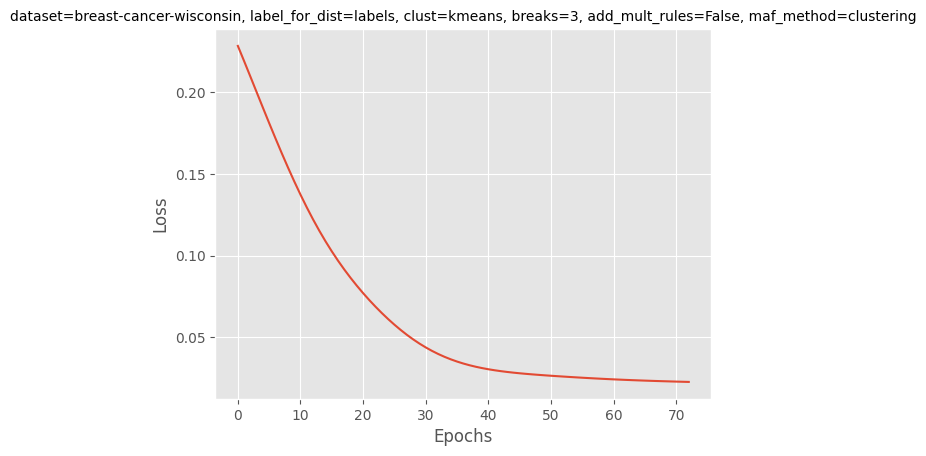

24-04-29 01:37:15 [DEBUG] Accuracy:  0.98
24-04-29 01:37:15 [DEBUG] F1 Score: 0.97
24-04-29 01:37:15 [DEBUG] Confusion Matrix: 
[[129   3]
 [  2  71]]
24-04-29 01:37:15 [INFO] ------------------------------
24-04-29 01:37:15 [INFO] Step 5: Run DST (dataset=breast-cancer-wisconsin, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:37:15 [DEBUG] 	Model init done


Optimization started
Processing epoch	117	0.0308	

24-04-29 01:37:35 [DEBUG] 	Model fit done
24-04-29 01:37:35 [INFO] Step 6: Inference done
24-04-29 01:37:35 [DEBUG] Training Time: 19.63s
24-04-29 01:37:35 [DEBUG] Epochs: 117
24-04-29 01:37:35 [DEBUG] Min Loss: 0.031



Training time: 19.63s, epochs: 117

Least training loss reached: 0.031
DSModelMultiQ(
  DS Classifier using 36 rules
  
  Rule 1: clump_thickness < 2.569
  	C1: 0.336	C2: 0.000	Unc: 0.664
  
  Rule 2: 2.569 < clump_thickness < 4.454
  	C1: 0.368	C2: 0.000	Unc: 0.632
  
  Rule 3: 4.454 < clump_thickness < 6.339
  	C1: 0.193	C2: 0.000	Unc: 0.807
  
  Rule 4: clump_thickness > 6.339
  	C1: 0.000	C2: 0.372	Unc: 0.628
  
  Rule 5: size_uniformity < 1.066
  	C1: 0.313	C2: 0.000	Unc: 0.687
  
  Rule 6: 1.066 < size_uniformity < 3.100
  	C1: 0.011	C2: 0.172	Unc: 0.817
  
  Rule 7: 3.100 < size_uniformity < 5.134
  	C1: 0.000	C2: 0.439	Unc: 0.561
  
  Rule 8: size_uniformity > 5.134
  	C1: 0.000	C2: 0.362	Unc: 0.638
  
  Rule 9: shape_uniformity < 1.176
  	C1: 0.373	C2: 0.000	Unc: 0.627
  
  Rule 10: 1.176 < shape_uniformity < 3.136
  	C1: 0.150	C2: 0.031	Unc: 0.820
  
  Rule 11: 3.136 < shape_uniformity < 5.096
  	C1: 0.000	C2: 0.411	Unc: 0.589
  
  Rule 12: shape_uniformity > 5.096
  	C1: 0.

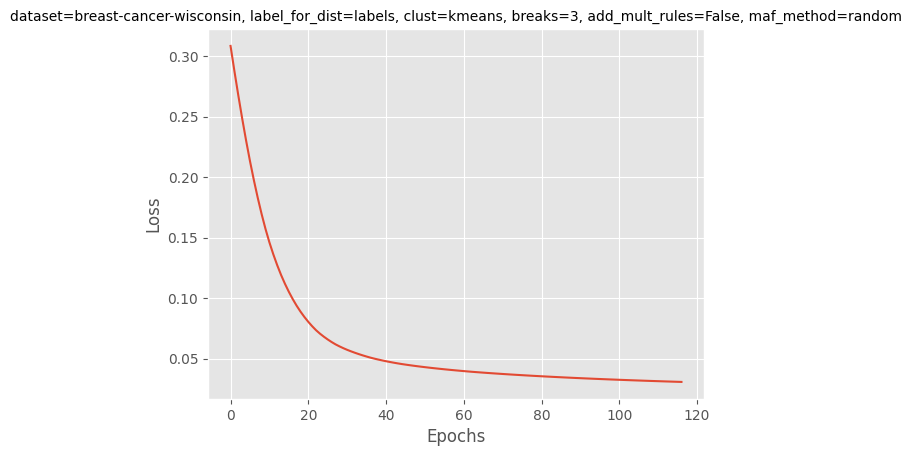

24-04-29 01:37:35 [DEBUG] Accuracy:  0.98
24-04-29 01:37:35 [DEBUG] F1 Score: 0.97
24-04-29 01:37:35 [DEBUG] Confusion Matrix: 
[[129   3]
 [  2  71]]
24-04-29 01:37:35 [INFO] ------------------------------
24-04-29 01:37:35 [DEBUG] Dataset: breast-cancer-wisconsin | Shape: (683, 10)
24-04-29 01:37:35 [DEBUG] (683, 10) droped columns with more than 20% missing values
24-04-29 01:37:35 [DEBUG] (683, 10) drop rows with missing values
24-04-29 01:37:35 [DEBUG] (683, 10) drop non-numeric columns
24-04-29 01:37:35 [INFO] ------ Dataset: breast-cancer-wisconsin | Shape: (683, 10) | Label ratio: 0.65 -------
24-04-29 01:37:35 [INFO] Step 0: Data split done | 478 - 205
24-04-29 01:37:35 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:37:35 [INFO] Step 2.1: Performing dbscan clustering
24-04-29 01:37:35 [INFO] Step 2.1: Clustering and inference done
24-04-29 01:37:35 [DEBUG] Evaluation on train
24-04-29 01:37:35 [DEBUG] 	silhouette = 0.468
24-04-29 01:37:35 [DEBUG] 	calinski_harabasz = 32

Found the desired number of clusters: 2 at eps=2.010000000000001
Optimization started
Processing epoch	88	0.0252	

24-04-29 01:37:57 [DEBUG] 	Model fit done
24-04-29 01:37:57 [INFO] Step 6: Inference done
24-04-29 01:37:57 [DEBUG] Training Time: 20.70s
24-04-29 01:37:57 [DEBUG] Epochs: 88
24-04-29 01:37:57 [DEBUG] Min Loss: 0.025



Training time: 20.70s, epochs: 88

Least training loss reached: 0.025
DSModelMultiQ(
  DS Classifier using 36 rules
  
  Rule 1: clump_thickness < 2.569
  	C1: 0.345	C2: 0.122	Unc: 0.533
  
  Rule 2: 2.569 < clump_thickness < 4.454
  	C1: 0.381	C2: 0.126	Unc: 0.493
  
  Rule 3: 4.454 < clump_thickness < 6.339
  	C1: 0.656	C2: 0.086	Unc: 0.258
  
  Rule 4: clump_thickness > 6.339
  	C1: 0.000	C2: 0.818	Unc: 0.182
  
  Rule 5: size_uniformity < 1.066
  	C1: 0.292	C2: 0.151	Unc: 0.557
  
  Rule 6: 1.066 < size_uniformity < 3.100
  	C1: 0.541	C2: 0.159	Unc: 0.299
  
  Rule 7: 3.100 < size_uniformity < 5.134
  	C1: 0.171	C2: 0.560	Unc: 0.270
  
  Rule 8: size_uniformity > 5.134
  	C1: 0.055	C2: 0.703	Unc: 0.242
  
  Rule 9: shape_uniformity < 1.176
  	C1: 0.296	C2: 0.147	Unc: 0.557
  
  Rule 10: 1.176 < shape_uniformity < 3.136
  	C1: 0.512	C2: 0.162	Unc: 0.326
  
  Rule 11: 3.136 < shape_uniformity < 5.096
  	C1: 0.098	C2: 0.692	Unc: 0.210
  
  Rule 12: shape_uniformity > 5.096
  	C1: 0.2

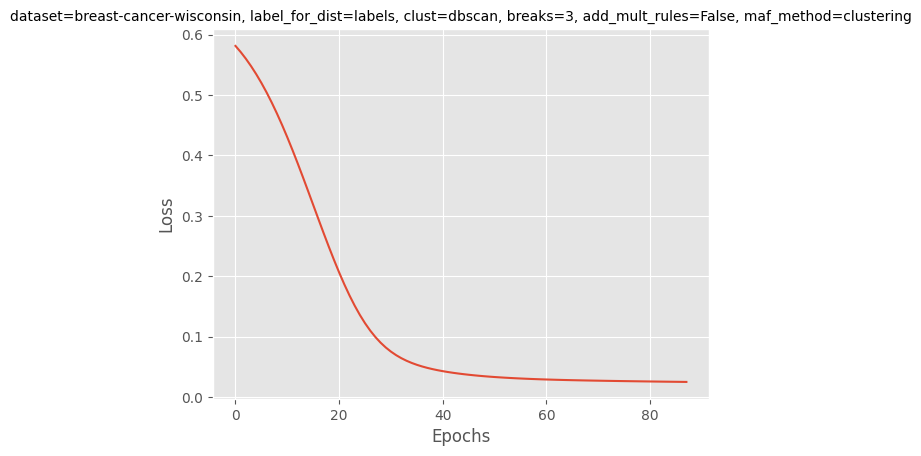

24-04-29 01:37:57 [DEBUG] Accuracy:  0.96
24-04-29 01:37:57 [DEBUG] F1 Score: 0.94
24-04-29 01:37:57 [DEBUG] Confusion Matrix: 
[[129   3]
 [  5  68]]
24-04-29 01:37:57 [INFO] ------------------------------
24-04-29 01:37:57 [INFO] Step 5: Run DST (dataset=breast-cancer-wisconsin, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:37:57 [DEBUG] 	Model init done


Optimization started
Processing epoch	112	0.0299	
Training time: 24.96s, epochs: 112

Least training loss reached: 0.030
DSModelMultiQ(
  DS Classifier using 36 rules
  
  Rule 1: clump_thickness < 2.569
  	C1: 0.341	C2: 0.000	Unc: 0.659
  
  Rule 2: 2.569 < clump_thickness < 4.454
  	C1: 0.223	C2: 0.000	Unc: 0.777
  
  Rule 3: 4.454 < clump_thickness < 6.339
  	C1: 0.134	C2: 0.037	Unc: 0.829
  
  Rule 4: clump_thickness > 6.339
  	C1: 0.000	C2: 0.409	Unc: 0.591
  
  Rule 5: size_uniformity < 1.066
  	C1: 0.346	C2: 0.000	Unc: 0.654
  
  Rule 6: 1.066 < size_uniformity < 3.100
  	C1: 0.000	C2: 0.195	Unc: 0.805
  
  Rule 7: 3.100 < size_uniformity < 5.134
  	C1: 0.000	C2: 0.388	Unc: 0.612
  
  Rule 8: size_uniformity > 5.134
  	C1: 0.000	C2: 0.382	Unc: 0.618
  
  Rule 9: shape_uniformity < 1.176
  	C1: 0.229	C2: 0.000	Unc: 0.771
  
  Rule 10: 1.176 < shape_uniformity < 3.136
  	C1: 0.115	C2: 0.064	Unc: 0.821
  
  Rule 11: 3.136 < shape_uniformity < 5.096
  	C1: 0.000	C2: 0.345	Unc: 0.655

24-04-29 01:38:22 [DEBUG] 	Model fit done
24-04-29 01:38:22 [INFO] Step 6: Inference done
24-04-29 01:38:22 [DEBUG] Training Time: 24.96s
24-04-29 01:38:22 [DEBUG] Epochs: 112
24-04-29 01:38:22 [DEBUG] Min Loss: 0.030




Most important rules for class 0

	[0.346] R4: size_uniformity < 1.066
			0: 0.346	1: 0.000	Unc: 0.654

	[0.341] R0: clump_thickness < 2.569
			0: 0.341	1: 0.000	Unc: 0.659

	[0.338] R20: bare_nucleoli < 1.091
			0: 0.338	1: 0.000	Unc: 0.662

	[0.323] R24: bland_chromatin < 1.781
			0: 0.323	1: 0.000	Unc: 0.677

	[0.318] R29: 0.823 < normal_nucleoli < 2.925
			0: 0.318	1: 0.000	Unc: 0.682

	[0.265] R25: 1.781 < bland_chromatin < 3.456
			0: 0.265	1: 0.000	Unc: 0.735

	[0.249] R16: epithelial_size < 1.720
			0: 0.249	1: 0.000	Unc: 0.751

	[0.243] R33: 0.411 < mitoses < 1.636
			0: 0.243	1: 0.000	Unc: 0.757

	[0.240] R17: 1.720 < epithelial_size < 3.176
			0: 0.240	1: 0.000	Unc: 0.760

	[0.229] R8: shape_uniformity < 1.176
			0: 0.229	1: 0.000	Unc: 0.771

	[0.223] R1: 2.569 < clump_thickness < 4.454
			0: 0.223	1: 0.000	Unc: 0.777

	[0.222] R13: 0.895 < marginal_adhesion < 2.774
			0: 0.222	1: 0.000	Unc: 0.778

Most important rules for class 1

	[0.457] R30: 2.925 < normal_nucleoli < 5

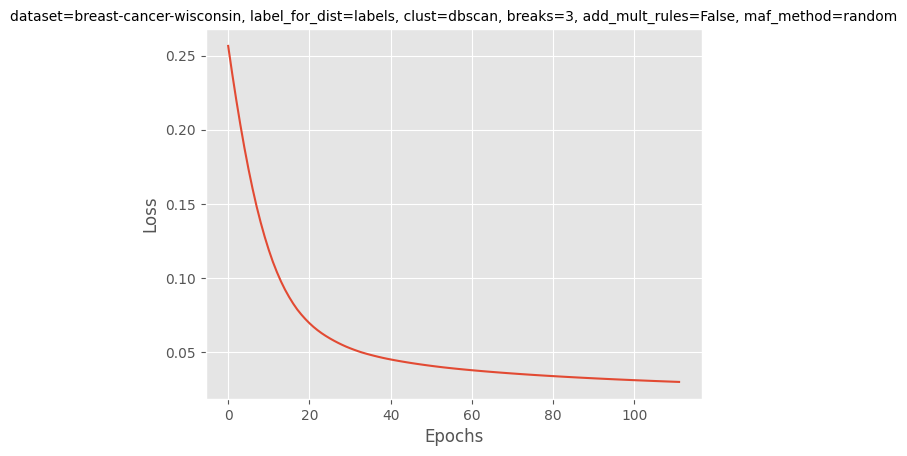

24-04-29 01:38:23 [DEBUG] Accuracy:  0.97
24-04-29 01:38:23 [DEBUG] F1 Score: 0.96
24-04-29 01:38:23 [DEBUG] Confusion Matrix: 
[[128   4]
 [  2  71]]
24-04-29 01:38:23 [INFO] ------------------------------
 33%|███▎      | 2/6 [11:09<19:23, 290.95s/it]24-04-29 01:38:23 [DEBUG] Dataset: gaussian_df | Shape: (500, 3)
24-04-29 01:38:23 [DEBUG] (500, 3) droped columns with more than 20% missing values
24-04-29 01:38:23 [DEBUG] (500, 3) drop rows with missing values
24-04-29 01:38:23 [DEBUG] (500, 3) drop non-numeric columns
24-04-29 01:38:23 [INFO] ------ Dataset: gaussian_df | Shape: (500, 3) | Label ratio: 0.50 -------
24-04-29 01:38:23 [INFO] Step 0: Data split done | 350 - 150
24-04-29 01:38:23 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:38:23 [INFO] Step 2.1: Performing kmeans clustering
24-04-29 01:38:23 [INFO] Step 2.1: Clustering and inference done
24-04-29 01:38:23 [DEBUG] Evaluation on train
24-04-29 01:38:23 [DEBUG] 	silhouette = 0.719
24-04-29 01:38:23 [DEBUG] 	calin

Optimization started
Processing epoch	100	0.0168	

24-04-29 01:38:39 [DEBUG] 	Model fit done
24-04-29 01:38:39 [INFO] Step 6: Inference done
24-04-29 01:38:39 [DEBUG] Training Time: 15.79s
24-04-29 01:38:39 [DEBUG] Epochs: 100
24-04-29 01:38:39 [DEBUG] Min Loss: 0.017



Training time: 15.79s, epochs: 100

Least training loss reached: 0.017
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < 0.321
  	C1: 0.000	C2: 0.846	Unc: 0.154
  
  Rule 2: 0.321 < x < 0.705
  	C1: 0.001	C2: 0.725	Unc: 0.274
  
  Rule 3: 0.705 < x < 1.089
  	C1: 0.722	C2: 0.000	Unc: 0.278
  
  Rule 4: x > 1.089
  	C1: 0.825	C2: 0.000	Unc: 0.175
  
  Rule 5: y < 0.228
  	C1: 0.789	C2: 0.000	Unc: 0.211
  
  Rule 6: 0.228 < y < 0.530
  	C1: 0.639	C2: 0.132	Unc: 0.229
  
  Rule 7: 0.530 < y < 0.833
  	C1: 0.221	C2: 0.533	Unc: 0.246
  
  Rule 8: y > 0.833
  	C1: 0.000	C2: 0.771	Unc: 0.229
)


Most important rules for class 0

	[0.825] R3: x > 1.089
			0: 0.825	1: 0.000	Unc: 0.175

	[0.789] R4: y < 0.228
			0: 0.789	1: 0.000	Unc: 0.211

	[0.722] R2: 0.705 < x < 1.089
			0: 0.722	1: 0.000	Unc: 0.278

	[0.702] R5: 0.228 < y < 0.530
			0: 0.639	1: 0.132	Unc: 0.229

	[0.408] R6: 0.530 < y < 0.833
			0: 0.221	1: 0.533	Unc: 0.246

Most important rules for class 1

	[0.846] R0: x < 0.

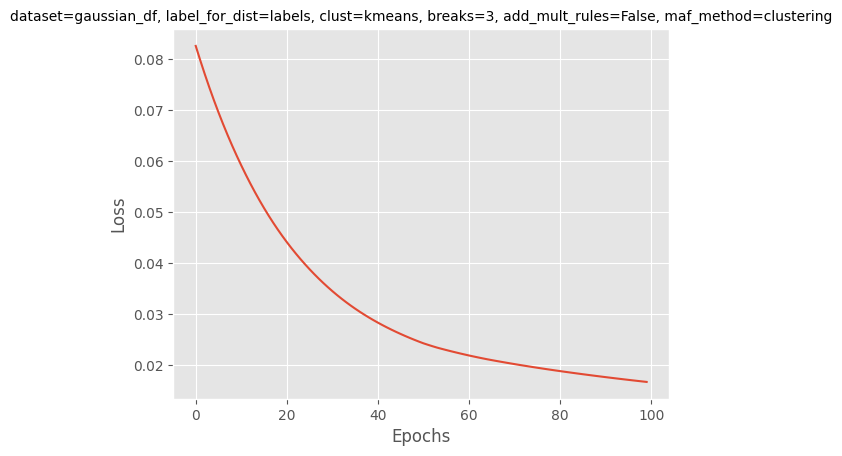

24-04-29 01:38:40 [DEBUG] Accuracy:  0.99
24-04-29 01:38:40 [DEBUG] F1 Score: 0.99
24-04-29 01:38:40 [DEBUG] Confusion Matrix: 
[[69  2]
 [ 0 79]]
24-04-29 01:38:40 [INFO] ------------------------------
24-04-29 01:38:40 [INFO] Step 5: Run DST (dataset=gaussian_df, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:38:40 [DEBUG] 	Model init done


Optimization started
Processing epoch	264	0.0237	

24-04-29 01:39:19 [DEBUG] 	Model fit done
24-04-29 01:39:19 [INFO] Step 6: Inference done
24-04-29 01:39:19 [DEBUG] Training Time: 39.06s
24-04-29 01:39:19 [DEBUG] Epochs: 264
24-04-29 01:39:19 [DEBUG] Min Loss: 0.024



Training time: 39.06s, epochs: 264

Least training loss reached: 0.024
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < 0.321
  	C1: 0.000	C2: 0.710	Unc: 0.290
  
  Rule 2: 0.321 < x < 0.705
  	C1: 0.000	C2: 0.686	Unc: 0.314
  
  Rule 3: 0.705 < x < 1.089
  	C1: 0.673	C2: 0.000	Unc: 0.327
  
  Rule 4: x > 1.089
  	C1: 0.789	C2: 0.000	Unc: 0.211
  
  Rule 5: y < 0.228
  	C1: 0.735	C2: 0.000	Unc: 0.265
  
  Rule 6: 0.228 < y < 0.530
  	C1: 0.520	C2: 0.010	Unc: 0.471
  
  Rule 7: 0.530 < y < 0.833
  	C1: 0.004	C2: 0.518	Unc: 0.478
  
  Rule 8: y > 0.833
  	C1: 0.000	C2: 0.713	Unc: 0.287
)


Most important rules for class 0

	[0.789] R3: x > 1.089
			0: 0.789	1: 0.000	Unc: 0.211

	[0.735] R4: y < 0.228
			0: 0.735	1: 0.000	Unc: 0.265

	[0.673] R2: 0.705 < x < 1.089
			0: 0.673	1: 0.000	Unc: 0.327

	[0.524] R5: 0.228 < y < 0.530
			0: 0.520	1: 0.010	Unc: 0.471

Most important rules for class 1

	[0.713] R7: y > 0.833
			0: 0.000	1: 0.713	Unc: 0.287

	[0.710] R0: x < 0.321
			0

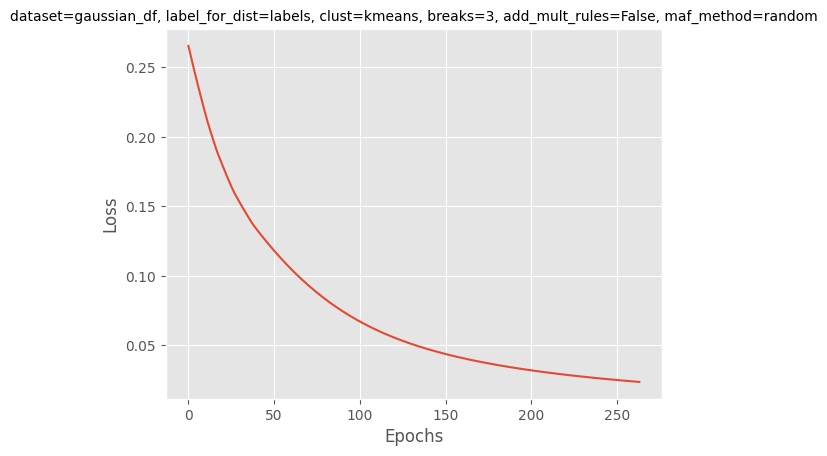

24-04-29 01:39:19 [DEBUG] Accuracy:  0.99
24-04-29 01:39:19 [DEBUG] F1 Score: 0.99
24-04-29 01:39:19 [DEBUG] Confusion Matrix: 
[[69  2]
 [ 0 79]]
24-04-29 01:39:19 [INFO] ------------------------------
24-04-29 01:39:19 [DEBUG] Dataset: gaussian_df | Shape: (500, 3)
24-04-29 01:39:19 [DEBUG] (500, 3) droped columns with more than 20% missing values
24-04-29 01:39:19 [DEBUG] (500, 3) drop rows with missing values
24-04-29 01:39:19 [DEBUG] (500, 3) drop non-numeric columns
24-04-29 01:39:19 [INFO] ------ Dataset: gaussian_df | Shape: (500, 3) | Label ratio: 0.50 -------
24-04-29 01:39:19 [INFO] Step 0: Data split done | 350 - 150
24-04-29 01:39:19 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:39:19 [INFO] Step 2.1: Performing dbscan clustering
24-04-29 01:39:19 [INFO] Step 2.1: Clustering and inference done
24-04-29 01:39:19 [DEBUG] Evaluation on train
24-04-29 01:39:19 [DEBUG] 	silhouette = 0.586
24-04-29 01:39:19 [DEBUG] 	calinski_harabasz = 711.825
24-04-29 01:39:19 [DEBUG] E

Found the desired number of clusters: 2 at eps=0.31
Optimization started
Processing epoch	136	0.0175	

24-04-29 01:39:40 [DEBUG] 	Model fit done
24-04-29 01:39:40 [INFO] Step 6: Inference done
24-04-29 01:39:40 [DEBUG] Training Time: 20.06s
24-04-29 01:39:40 [DEBUG] Epochs: 137
24-04-29 01:39:40 [DEBUG] Min Loss: 0.017


Processing epoch	137	0.0174	
Training time: 20.06s, epochs: 137

Least training loss reached: 0.017
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < 0.321
  	C1: 0.000	C2: 0.865	Unc: 0.135
  
  Rule 2: 0.321 < x < 0.705
  	C1: 0.048	C2: 0.737	Unc: 0.216
  
  Rule 3: 0.705 < x < 1.089
  	C1: 0.774	C2: 0.012	Unc: 0.214
  
  Rule 4: x > 1.089
  	C1: 0.733	C2: 0.000	Unc: 0.267
  
  Rule 5: y < 0.228
  	C1: 0.729	C2: 0.000	Unc: 0.271
  
  Rule 6: 0.228 < y < 0.530
  	C1: 0.663	C2: 0.084	Unc: 0.253
  
  Rule 7: 0.530 < y < 0.833
  	C1: 0.218	C2: 0.469	Unc: 0.313
  
  Rule 8: y > 0.833
  	C1: 0.000	C2: 0.867	Unc: 0.133
)


Most important rules for class 0

	[0.780] R2: 0.705 < x < 1.089
			0: 0.774	1: 0.012	Unc: 0.214

	[0.733] R3: x > 1.089
			0: 0.733	1: 0.000	Unc: 0.267

	[0.729] R4: y < 0.228
			0: 0.729	1: 0.000	Unc: 0.271

	[0.703] R5: 0.228 < y < 0.530
			0: 0.663	1: 0.084	Unc: 0.253

	[0.387] R6: 0.530 < y < 0.833
			0: 0.218	1: 0.469	Unc: 0.313

Most important rules for 

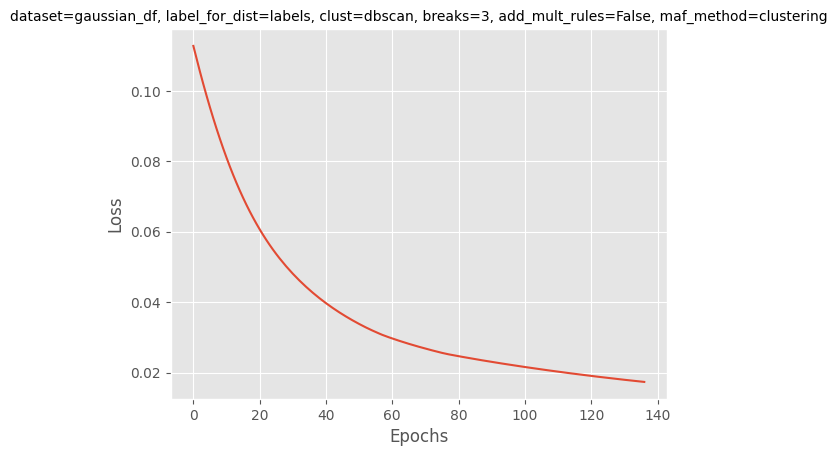

24-04-29 01:39:40 [DEBUG] Accuracy:  0.99
24-04-29 01:39:40 [DEBUG] F1 Score: 0.99
24-04-29 01:39:40 [DEBUG] Confusion Matrix: 
[[69  2]
 [ 0 79]]
24-04-29 01:39:40 [INFO] ------------------------------
24-04-29 01:39:40 [INFO] Step 5: Run DST (dataset=gaussian_df, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:39:40 [DEBUG] 	Model init done


Optimization started
Processing epoch	256	0.0227	

24-04-29 01:40:24 [DEBUG] 	Model fit done
24-04-29 01:40:24 [INFO] Step 6: Inference done
24-04-29 01:40:24 [DEBUG] Training Time: 44.21s
24-04-29 01:40:24 [DEBUG] Epochs: 256
24-04-29 01:40:24 [DEBUG] Min Loss: 0.023



Training time: 44.21s, epochs: 256

Least training loss reached: 0.023
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < 0.321
  	C1: 0.000	C2: 0.832	Unc: 0.168
  
  Rule 2: 0.321 < x < 0.705
  	C1: 0.000	C2: 0.708	Unc: 0.292
  
  Rule 3: 0.705 < x < 1.089
  	C1: 0.683	C2: 0.000	Unc: 0.317
  
  Rule 4: x > 1.089
  	C1: 0.690	C2: 0.000	Unc: 0.310
  
  Rule 5: y < 0.228
  	C1: 0.715	C2: 0.000	Unc: 0.285
  
  Rule 6: 0.228 < y < 0.530
  	C1: 0.613	C2: 0.000	Unc: 0.387
  
  Rule 7: 0.530 < y < 0.833
  	C1: 0.023	C2: 0.366	Unc: 0.611
  
  Rule 8: y > 0.833
  	C1: 0.000	C2: 0.672	Unc: 0.328
)


Most important rules for class 0

	[0.715] R4: y < 0.228
			0: 0.715	1: 0.000	Unc: 0.285

	[0.690] R3: x > 1.089
			0: 0.690	1: 0.000	Unc: 0.310

	[0.683] R2: 0.705 < x < 1.089
			0: 0.683	1: 0.000	Unc: 0.317

	[0.613] R5: 0.228 < y < 0.530
			0: 0.613	1: 0.000	Unc: 0.387

Most important rules for class 1

	[0.832] R0: x < 0.321
			0: 0.000	1: 0.832	Unc: 0.168

	[0.708] R1: 0.321 < x < 0.

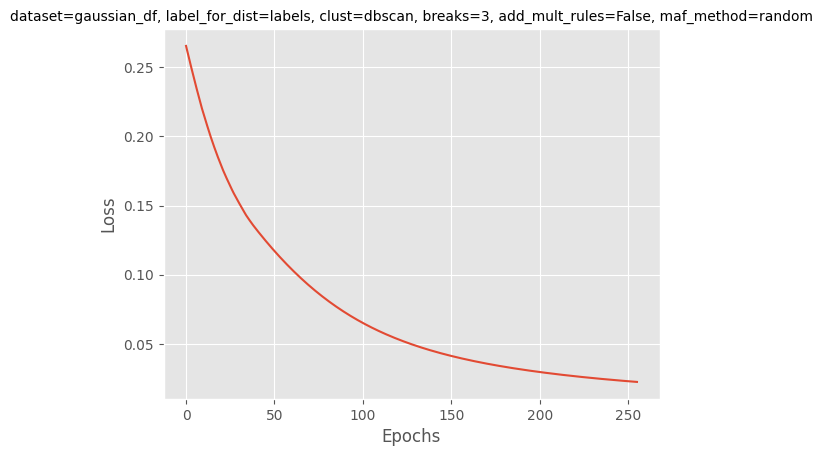

24-04-29 01:40:25 [DEBUG] Accuracy:  0.98
24-04-29 01:40:25 [DEBUG] F1 Score: 0.98
24-04-29 01:40:25 [DEBUG] Confusion Matrix: 
[[69  2]
 [ 1 78]]
24-04-29 01:40:25 [INFO] ------------------------------
 50%|█████     | 3/6 [13:11<10:41, 213.82s/it]24-04-29 01:40:25 [DEBUG] Dataset: rectangle_df | Shape: (1263, 3)
24-04-29 01:40:25 [DEBUG] (1263, 3) droped columns with more than 20% missing values
24-04-29 01:40:25 [DEBUG] (1263, 3) drop rows with missing values
24-04-29 01:40:25 [DEBUG] (1263, 3) drop non-numeric columns
24-04-29 01:40:25 [INFO] ------ Dataset: rectangle_df | Shape: (1263, 3) | Label ratio: 0.51 -------
24-04-29 01:40:25 [INFO] Step 0: Data split done | 884 - 379
24-04-29 01:40:25 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:40:25 [INFO] Step 2.1: Performing kmeans clustering
24-04-29 01:40:25 [INFO] Step 2.1: Clustering and inference done
24-04-29 01:40:25 [DEBUG] Evaluation on train
24-04-29 01:40:25 [DEBUG] 	silhouette = 0.57
24-04-29 01:40:25 [DEBUG] 	cal

Optimization started
Processing epoch	167	0.0062	

24-04-29 01:41:27 [DEBUG] 	Model fit done
24-04-29 01:41:27 [INFO] Step 6: Inference done
24-04-29 01:41:27 [DEBUG] Training Time: 61.03s
24-04-29 01:41:27 [DEBUG] Epochs: 167
24-04-29 01:41:27 [DEBUG] Min Loss: 0.006



Training time: 61.03s, epochs: 167

Least training loss reached: 0.006
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < -0.403
  	C1: 0.305	C2: 0.406	Unc: 0.288
  
  Rule 2: -0.403 < x < -0.008
  	C1: 0.351	C2: 0.320	Unc: 0.330
  
  Rule 3: -0.008 < x < 0.388
  	C1: 0.374	C2: 0.308	Unc: 0.318
  
  Rule 4: x > 0.388
  	C1: 0.303	C2: 0.368	Unc: 0.328
  
  Rule 5: y < -0.452
  	C1: 0.935	C2: 0.000	Unc: 0.065
  
  Rule 6: -0.452 < y < -0.029
  	C1: 0.939	C2: 0.000	Unc: 0.061
  
  Rule 7: -0.029 < y < 0.393
  	C1: 0.000	C2: 0.882	Unc: 0.118
  
  Rule 8: y > 0.393
  	C1: 0.000	C2: 0.902	Unc: 0.098
)


Most important rules for class 0

	[0.939] R5: -0.452 < y < -0.029
			0: 0.939	1: 0.000	Unc: 0.061

	[0.935] R4: y < -0.452
			0: 0.935	1: 0.000	Unc: 0.065

	[0.505] R2: -0.008 < x < 0.388
			0: 0.374	1: 0.308	Unc: 0.318

	[0.485] R1: -0.403 < x < -0.008
			0: 0.351	1: 0.320	Unc: 0.330

	[0.466] R0: x < -0.403
			0: 0.305	1: 0.406	Unc: 0.288

	[0.451] R3: x > 0.388
			0: 0.303	1: 

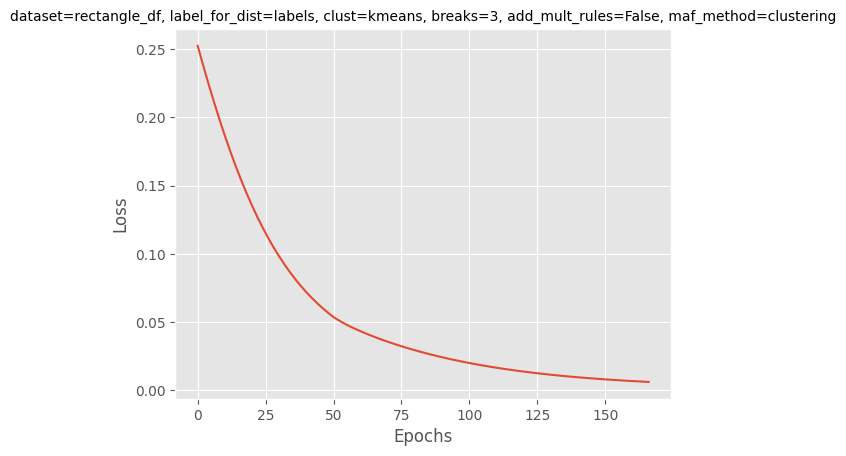

24-04-29 01:41:27 [DEBUG] Accuracy:  1.00
24-04-29 01:41:27 [DEBUG] F1 Score: 1.00
24-04-29 01:41:27 [DEBUG] Confusion Matrix: 
[[188   0]
 [  0 191]]
24-04-29 01:41:27 [INFO] ------------------------------
24-04-29 01:41:27 [INFO] Step 5: Run DST (dataset=rectangle_df, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:41:27 [DEBUG] 	Model init done


Optimization started
Processing epoch	275	0.0077	

24-04-29 01:43:06 [DEBUG] 	Model fit done
24-04-29 01:43:06 [INFO] Step 6: Inference done
24-04-29 01:43:06 [DEBUG] Training Time: 98.64s
24-04-29 01:43:06 [DEBUG] Epochs: 275
24-04-29 01:43:06 [DEBUG] Min Loss: 0.008



Training time: 98.64s, epochs: 275

Least training loss reached: 0.008
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < -0.403
  	C1: 0.167	C2: 0.014	Unc: 0.819
  
  Rule 2: -0.403 < x < -0.008
  	C1: 0.184	C2: 0.000	Unc: 0.816
  
  Rule 3: -0.008 < x < 0.388
  	C1: 0.253	C2: 0.000	Unc: 0.747
  
  Rule 4: x > 0.388
  	C1: 0.190	C2: 0.000	Unc: 0.810
  
  Rule 5: y < -0.452
  	C1: 0.884	C2: 0.000	Unc: 0.116
  
  Rule 6: -0.452 < y < -0.029
  	C1: 0.879	C2: 0.000	Unc: 0.121
  
  Rule 7: -0.029 < y < 0.393
  	C1: 0.000	C2: 0.917	Unc: 0.083
  
  Rule 8: y > 0.393
  	C1: 0.000	C2: 0.926	Unc: 0.074
)


Most important rules for class 0

	[0.884] R4: y < -0.452
			0: 0.884	1: 0.000	Unc: 0.116

	[0.879] R5: -0.452 < y < -0.029
			0: 0.879	1: 0.000	Unc: 0.121

	[0.253] R2: -0.008 < x < 0.388
			0: 0.253	1: 0.000	Unc: 0.747

Most important rules for class 1

	[0.926] R7: y > 0.393
			0: 0.000	1: 0.926	Unc: 0.074

	[0.917] R6: -0.029 < y < 0.393
			0: 0.000	1: 0.917	Unc: 0.083


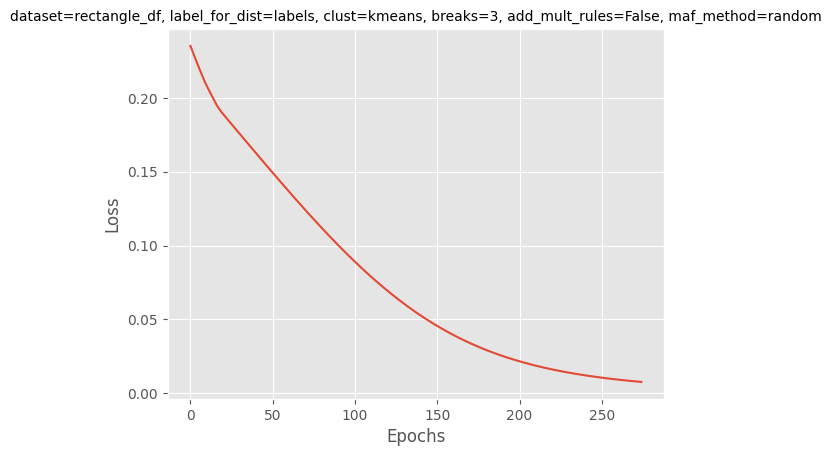

24-04-29 01:43:06 [DEBUG] Accuracy:  1.00
24-04-29 01:43:06 [DEBUG] F1 Score: 1.00
24-04-29 01:43:06 [DEBUG] Confusion Matrix: 
[[188   0]
 [  0 191]]
24-04-29 01:43:06 [INFO] ------------------------------
24-04-29 01:43:06 [DEBUG] Dataset: rectangle_df | Shape: (1263, 3)
24-04-29 01:43:06 [DEBUG] (1263, 3) droped columns with more than 20% missing values
24-04-29 01:43:06 [DEBUG] (1263, 3) drop rows with missing values
24-04-29 01:43:06 [DEBUG] (1263, 3) drop non-numeric columns
24-04-29 01:43:06 [INFO] ------ Dataset: rectangle_df | Shape: (1263, 3) | Label ratio: 0.51 -------
24-04-29 01:43:06 [INFO] Step 0: Data split done | 884 - 379
24-04-29 01:43:06 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:43:06 [INFO] Step 2.1: Performing dbscan clustering
24-04-29 01:43:06 [INFO] Step 2.1: Clustering and inference done
24-04-29 01:43:06 [DEBUG] Evaluation on train
24-04-29 01:43:06 [DEBUG] 	silhouette = 0.57
24-04-29 01:43:06 [DEBUG] 	calinski_harabasz = 1410.849
24-04-29 01:43:0

Found the desired number of clusters: 2 at eps=0.21000000000000002


24-04-29 01:43:07 [INFO] Step 4: Distance calculation done
24-04-29 01:43:07 [DEBUG] Train: 884
24-04-29 01:43:07 [INFO] Step 5: Run DST (dataset=rectangle_df, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=clustering)
24-04-29 01:43:07 [DEBUG] 	Model init done


Optimization started
Processing epoch	169	0.0064	

24-04-29 01:44:03 [DEBUG] 	Model fit done
24-04-29 01:44:03 [INFO] Step 6: Inference done
24-04-29 01:44:03 [DEBUG] Training Time: 55.95s
24-04-29 01:44:03 [DEBUG] Epochs: 169
24-04-29 01:44:03 [DEBUG] Min Loss: 0.006



Training time: 55.95s, epochs: 169

Least training loss reached: 0.006
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < -0.403
  	C1: 0.358	C2: 0.323	Unc: 0.320
  
  Rule 2: -0.403 < x < -0.008
  	C1: 0.394	C2: 0.313	Unc: 0.293
  
  Rule 3: -0.008 < x < 0.388
  	C1: 0.433	C2: 0.289	Unc: 0.278
  
  Rule 4: x > 0.388
  	C1: 0.399	C2: 0.315	Unc: 0.286
  
  Rule 5: y < -0.452
  	C1: 0.890	C2: 0.000	Unc: 0.110
  
  Rule 6: -0.452 < y < -0.029
  	C1: 0.940	C2: 0.000	Unc: 0.060
  
  Rule 7: -0.029 < y < 0.393
  	C1: 0.000	C2: 0.909	Unc: 0.091
  
  Rule 8: y > 0.393
  	C1: 0.000	C2: 0.932	Unc: 0.068
)


Most important rules for class 0

	[0.940] R5: -0.452 < y < -0.029
			0: 0.940	1: 0.000	Unc: 0.060

	[0.890] R4: y < -0.452
			0: 0.890	1: 0.000	Unc: 0.110

	[0.559] R2: -0.008 < x < 0.388
			0: 0.433	1: 0.289	Unc: 0.278

	[0.534] R3: x > 0.388
			0: 0.399	1: 0.315	Unc: 0.286

	[0.528] R1: -0.403 < x < -0.008
			0: 0.394	1: 0.313	Unc: 0.293

	[0.493] R0: x < -0.403
			0: 0.358	1: 

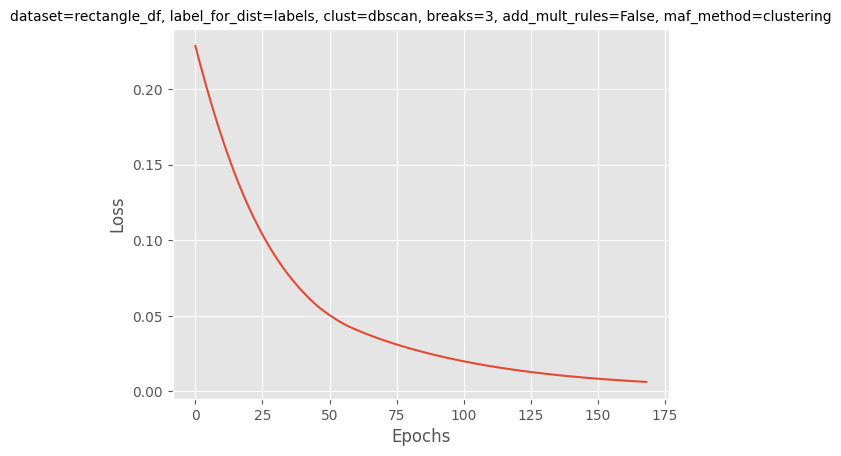

24-04-29 01:44:03 [DEBUG] Accuracy:  1.00
24-04-29 01:44:03 [DEBUG] F1 Score: 1.00
24-04-29 01:44:03 [DEBUG] Confusion Matrix: 
[[188   0]
 [  0 191]]
24-04-29 01:44:03 [INFO] ------------------------------
24-04-29 01:44:03 [INFO] Step 5: Run DST (dataset=rectangle_df, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:44:03 [DEBUG] 	Model init done


Optimization started
Processing epoch	279	0.0079	

24-04-29 01:45:44 [DEBUG] 	Model fit done
24-04-29 01:45:44 [INFO] Step 6: Inference done
24-04-29 01:45:44 [DEBUG] Training Time: 100.70s
24-04-29 01:45:44 [DEBUG] Epochs: 279
24-04-29 01:45:44 [DEBUG] Min Loss: 0.008



Training time: 100.70s, epochs: 279

Least training loss reached: 0.008
DSModelMultiQ(
  DS Classifier using 8 rules
  
  Rule 1: x < -0.403
  	C1: 0.104	C2: 0.083	Unc: 0.813
  
  Rule 2: -0.403 < x < -0.008
  	C1: 0.114	C2: 0.073	Unc: 0.813
  
  Rule 3: -0.008 < x < 0.388
  	C1: 0.171	C2: 0.030	Unc: 0.798
  
  Rule 4: x > 0.388
  	C1: 0.127	C2: 0.069	Unc: 0.804
  
  Rule 5: y < -0.452
  	C1: 0.895	C2: 0.000	Unc: 0.105
  
  Rule 6: -0.452 < y < -0.029
  	C1: 0.907	C2: 0.000	Unc: 0.093
  
  Rule 7: -0.029 < y < 0.393
  	C1: 0.000	C2: 0.905	Unc: 0.095
  
  Rule 8: y > 0.393
  	C1: 0.000	C2: 0.910	Unc: 0.090
)


Most important rules for class 0

	[0.907] R5: -0.452 < y < -0.029
			0: 0.907	1: 0.000	Unc: 0.093

	[0.895] R4: y < -0.452
			0: 0.895	1: 0.000	Unc: 0.105

Most important rules for class 1

	[0.910] R7: y > 0.393
			0: 0.000	1: 0.910	Unc: 0.090

	[0.905] R6: -0.029 < y < 0.393
			0: 0.000	1: 0.905	Unc: 0.095


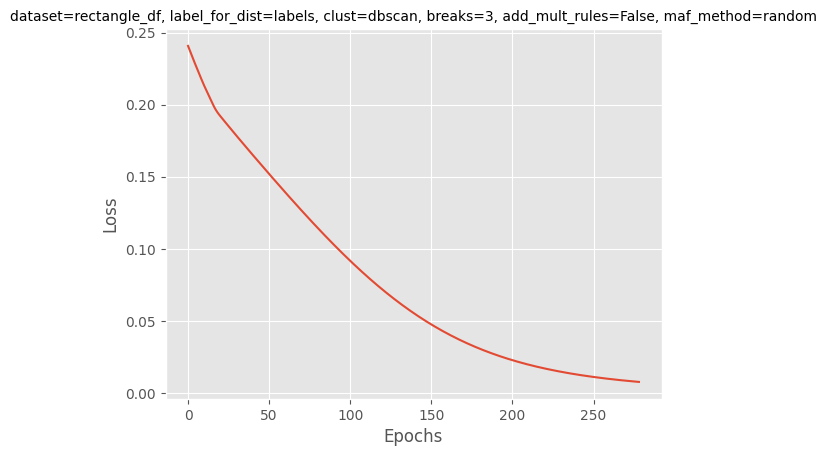

24-04-29 01:45:45 [DEBUG] Accuracy:  1.00
24-04-29 01:45:45 [DEBUG] F1 Score: 1.00
24-04-29 01:45:45 [DEBUG] Confusion Matrix: 
[[188   0]
 [  0 191]]
24-04-29 01:45:45 [INFO] ------------------------------
 67%|██████▋   | 4/6 [18:31<08:31, 255.62s/it]24-04-29 01:45:45 [DEBUG] Dataset: uniform_df | Shape: (500, 3)
24-04-29 01:45:45 [DEBUG] (500, 3) droped columns with more than 20% missing values
24-04-29 01:45:45 [DEBUG] (500, 3) drop rows with missing values
24-04-29 01:45:45 [DEBUG] (500, 3) drop non-numeric columns
24-04-29 01:45:45 [INFO] ------ Dataset: uniform_df | Shape: (500, 3) | Label ratio: 0.52 -------
24-04-29 01:45:45 [INFO] Step 0: Data split done | 350 - 150
24-04-29 01:45:45 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:45:45 [INFO] Step 2.1: Performing kmeans clustering
24-04-29 01:45:45 [INFO] Step 2.1: Clustering and inference done
24-04-29 01:45:45 [DEBUG] Evaluation on train
24-04-29 01:45:45 [DEBUG] 	silhouette = 0.776
24-04-29 01:45:45 [DEBUG] 	calinsk

Optimization started
Processing epoch	119	0.0349	

24-04-29 01:46:06 [DEBUG] 	Model fit done


Processing epoch	120	0.0348	
Training time: 20.68s, epochs: 120

Least training loss reached: 0.035
DSModelMultiQ(
  DS Classifier using 5 rules
  
  Rule 1: x < -1.604
  	C1: 0.904	C2: 0.000	Unc: 0.096
  
  Rule 2: -1.604 < x < 0.281
  	C1: 0.768	C2: 0.000	Unc: 0.232
  
  Rule 3: 0.281 < x < 2.167
  	C1: 0.000	C2: 0.933	Unc: 0.067
  
  Rule 4: x > 2.167
  	C1: 0.000	C2: 0.933	Unc: 0.067
  
  Rule 5: y = 0.0
  	C1: 0.313	C2: 0.399	Unc: 0.288
)


Most important rules for class 0

	[0.904] R0: x < -1.604
			0: 0.904	1: 0.000	Unc: 0.096

	[0.768] R1: -1.604 < x < 0.281
			0: 0.768	1: 0.000	Unc: 0.232

	[0.472] R4: y = 0.0
			0: 0.313	1: 0.399	Unc: 0.288

Most important rules for class 1

	[0.933] R2: 0.281 < x < 2.167
			0: 0.000	1: 0.933	Unc: 0.067

	[0.933] R3: x > 2.167
			0: 0.000	1: 0.933	Unc: 0.067

	[0.533] R4: y = 0.0
			0: 0.313	1: 0.399	Unc: 0.288


24-04-29 01:46:06 [INFO] Step 6: Inference done
24-04-29 01:46:06 [DEBUG] Training Time: 20.68s
24-04-29 01:46:06 [DEBUG] Epochs: 120
24-04-29 01:46:06 [DEBUG] Min Loss: 0.035


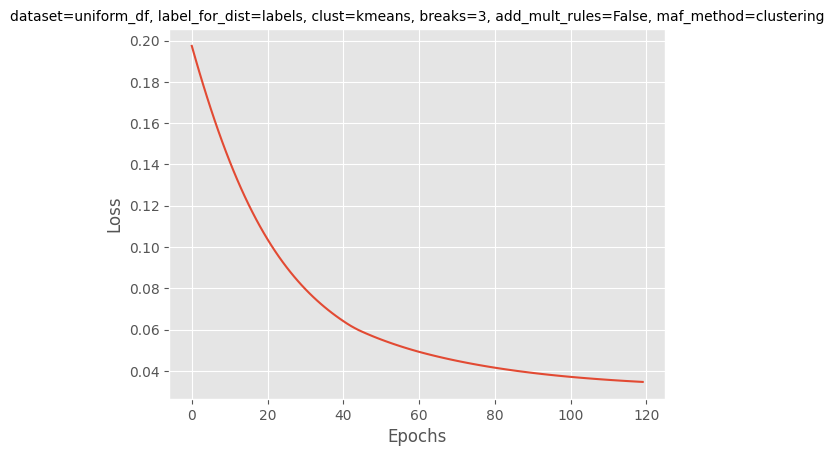

24-04-29 01:46:06 [DEBUG] Accuracy:  0.97
24-04-29 01:46:06 [DEBUG] F1 Score: 0.97
24-04-29 01:46:06 [DEBUG] Confusion Matrix: 
[[82  0]
 [ 4 64]]
24-04-29 01:46:06 [INFO] ------------------------------
24-04-29 01:46:06 [INFO] Step 5: Run DST (dataset=uniform_df, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:46:06 [DEBUG] 	Model init done


Optimization started
Processing epoch	272	0.0376	

24-04-29 01:46:46 [DEBUG] 	Model fit done
24-04-29 01:46:46 [INFO] Step 6: Inference done
24-04-29 01:46:46 [DEBUG] Training Time: 39.21s
24-04-29 01:46:46 [DEBUG] Epochs: 273
24-04-29 01:46:46 [DEBUG] Min Loss: 0.037


Processing epoch	273	0.0375	
Training time: 39.21s, epochs: 273

Least training loss reached: 0.037
DSModelMultiQ(
  DS Classifier using 5 rules
  
  Rule 1: x < -1.604
  	C1: 0.925	C2: 0.000	Unc: 0.075
  
  Rule 2: -1.604 < x < 0.281
  	C1: 0.777	C2: 0.000	Unc: 0.223
  
  Rule 3: 0.281 < x < 2.167
  	C1: 0.000	C2: 0.867	Unc: 0.133
  
  Rule 4: x > 2.167
  	C1: 0.000	C2: 0.856	Unc: 0.144
  
  Rule 5: y = 0.0
  	C1: 0.000	C2: 0.265	Unc: 0.735
)


Most important rules for class 0

	[0.925] R0: x < -1.604
			0: 0.925	1: 0.000	Unc: 0.075

	[0.777] R1: -1.604 < x < 0.281
			0: 0.777	1: 0.000	Unc: 0.223

Most important rules for class 1

	[0.867] R2: 0.281 < x < 2.167
			0: 0.000	1: 0.867	Unc: 0.133

	[0.856] R3: x > 2.167
			0: 0.000	1: 0.856	Unc: 0.144

	[0.265] R4: y = 0.0
			0: 0.000	1: 0.265	Unc: 0.735


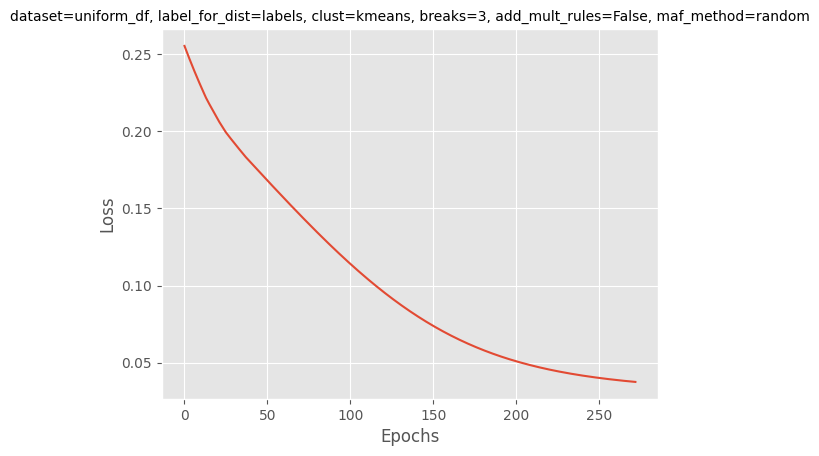

24-04-29 01:46:46 [DEBUG] Accuracy:  0.97
24-04-29 01:46:46 [DEBUG] F1 Score: 0.97
24-04-29 01:46:46 [DEBUG] Confusion Matrix: 
[[82  0]
 [ 4 64]]
24-04-29 01:46:46 [INFO] ------------------------------
24-04-29 01:46:46 [DEBUG] Dataset: uniform_df | Shape: (500, 3)
24-04-29 01:46:46 [DEBUG] (500, 3) droped columns with more than 20% missing values
24-04-29 01:46:46 [DEBUG] (500, 3) drop rows with missing values
24-04-29 01:46:46 [DEBUG] (500, 3) drop non-numeric columns
24-04-29 01:46:46 [INFO] ------ Dataset: uniform_df | Shape: (500, 3) | Label ratio: 0.52 -------
24-04-29 01:46:46 [INFO] Step 0: Data split done | 350 - 150
24-04-29 01:46:46 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:46:46 [INFO] Step 2.1: Performing dbscan clustering
24-04-29 01:46:46 [INFO] Step 2.1: Clustering and inference done
24-04-29 01:46:46 [DEBUG] Evaluation on train
24-04-29 01:46:46 [DEBUG] 	silhouette = 0.776
24-04-29 01:46:46 [DEBUG] 	calinski_harabasz = 2261.41
24-04-29 01:46:46 [DEBUG] Eva

Found the desired number of clusters: 2 at eps=0.11000000000000001
Optimization started
Processing epoch	139	0.0342	

24-04-29 01:47:12 [DEBUG] 	Model fit done
24-04-29 01:47:12 [INFO] Step 6: Inference done
24-04-29 01:47:12 [DEBUG] Training Time: 25.48s
24-04-29 01:47:12 [DEBUG] Epochs: 139
24-04-29 01:47:12 [DEBUG] Min Loss: 0.034



Training time: 25.48s, epochs: 139

Least training loss reached: 0.034
DSModelMultiQ(
  DS Classifier using 5 rules
  
  Rule 1: x < -1.604
  	C1: 0.985	C2: 0.000	Unc: 0.015
  
  Rule 2: -1.604 < x < 0.281
  	C1: 0.935	C2: 0.000	Unc: 0.065
  
  Rule 3: 0.281 < x < 2.167
  	C1: 0.000	C2: 0.557	Unc: 0.443
  
  Rule 4: x > 2.167
  	C1: 0.000	C2: 0.775	Unc: 0.225
  
  Rule 5: y = 0.0
  	C1: 0.000	C2: 0.750	Unc: 0.250
)


Most important rules for class 0

	[0.985] R0: x < -1.604
			0: 0.985	1: 0.000	Unc: 0.015

	[0.935] R1: -1.604 < x < 0.281
			0: 0.935	1: 0.000	Unc: 0.065

Most important rules for class 1

	[0.775] R3: x > 2.167
			0: 0.000	1: 0.775	Unc: 0.225

	[0.750] R4: y = 0.0
			0: 0.000	1: 0.750	Unc: 0.250

	[0.557] R2: 0.281 < x < 2.167
			0: 0.000	1: 0.557	Unc: 0.443


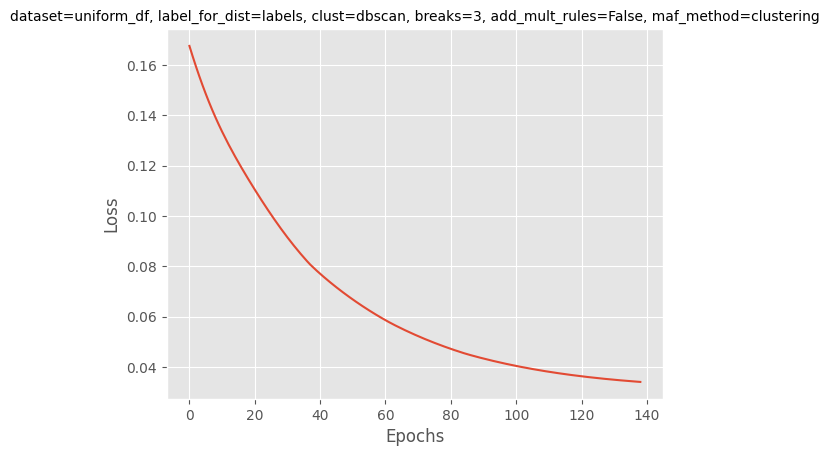

24-04-29 01:47:12 [DEBUG] Accuracy:  0.97
24-04-29 01:47:12 [DEBUG] F1 Score: 0.97
24-04-29 01:47:12 [DEBUG] Confusion Matrix: 
[[82  0]
 [ 4 64]]
24-04-29 01:47:12 [INFO] ------------------------------
24-04-29 01:47:12 [INFO] Step 5: Run DST (dataset=uniform_df, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:47:12 [DEBUG] 	Model init done


Optimization started
Processing epoch	270	0.0376	

24-04-29 01:47:58 [DEBUG] 	Model fit done
24-04-29 01:47:58 [INFO] Step 6: Inference done
24-04-29 01:47:58 [DEBUG] Training Time: 45.51s
24-04-29 01:47:58 [DEBUG] Epochs: 271
24-04-29 01:47:58 [DEBUG] Min Loss: 0.037


Processing epoch	271	0.0375	
Training time: 45.51s, epochs: 271

Least training loss reached: 0.037
DSModelMultiQ(
  DS Classifier using 5 rules
  
  Rule 1: x < -1.604
  	C1: 0.953	C2: 0.000	Unc: 0.047
  
  Rule 2: -1.604 < x < 0.281
  	C1: 0.867	C2: 0.000	Unc: 0.133
  
  Rule 3: 0.281 < x < 2.167
  	C1: 0.000	C2: 0.761	Unc: 0.239
  
  Rule 4: x > 2.167
  	C1: 0.000	C2: 0.800	Unc: 0.200
  
  Rule 5: y = 0.0
  	C1: 0.000	C2: 0.490	Unc: 0.510
)


Most important rules for class 0

	[0.953] R0: x < -1.604
			0: 0.953	1: 0.000	Unc: 0.047

	[0.867] R1: -1.604 < x < 0.281
			0: 0.867	1: 0.000	Unc: 0.133

Most important rules for class 1

	[0.800] R3: x > 2.167
			0: 0.000	1: 0.800	Unc: 0.200

	[0.761] R2: 0.281 < x < 2.167
			0: 0.000	1: 0.761	Unc: 0.239

	[0.490] R4: y = 0.0
			0: 0.000	1: 0.490	Unc: 0.510


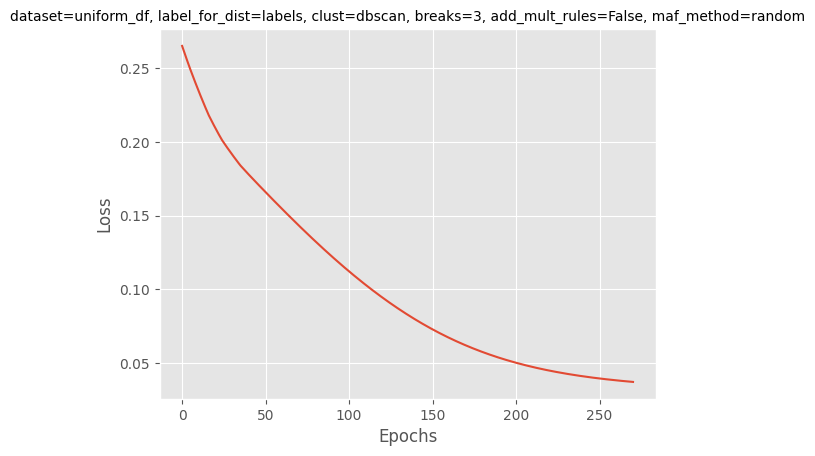

24-04-29 01:47:58 [DEBUG] Accuracy:  0.97
24-04-29 01:47:58 [DEBUG] F1 Score: 0.97
24-04-29 01:47:58 [DEBUG] Confusion Matrix: 
[[82  0]
 [ 4 64]]
24-04-29 01:47:58 [INFO] ------------------------------
 83%|████████▎ | 5/6 [20:44<03:31, 211.67s/it]24-04-29 01:47:58 [DEBUG] Dataset: wine | Shape: (6497, 14)
24-04-29 01:47:58 [DEBUG] (6497, 14) droped columns with more than 20% missing values
24-04-29 01:47:58 [DEBUG] (6497, 14) drop rows with missing values
24-04-29 01:47:58 [DEBUG] (6497, 14) drop non-numeric columns
24-04-29 01:47:58 [INFO] ------ Dataset: wine | Shape: (6497, 14) | Label ratio: 0.80 -------
24-04-29 01:47:58 [INFO] Step 0: Data split done | 4547 - 1950
24-04-29 01:47:58 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:47:58 [INFO] Step 2.1: Performing kmeans clustering
24-04-29 01:47:59 [INFO] Step 2.1: Clustering and inference done
24-04-29 01:47:59 [DEBUG] Evaluation on train
24-04-29 01:47:59 [DEBUG] 	silhouette = 0.296
24-04-29 01:47:59 [DEBUG] 	calinski_ha

Optimization started
Processing epoch	4	0.2003	

24-04-29 01:48:23 [DEBUG] 	Model fit done



Training time: 8.77s, epochs: 4

Least training loss reached: 0.200
DSModelMultiQ(
  DS Classifier using 50 rules
  
  Rule 1: fixed acidity < 6.338
  	C1: 0.583	C2: 0.208	Unc: 0.209
  
  Rule 2: 6.338 < fixed acidity < 7.220
  	C1: 0.611	C2: 0.195	Unc: 0.195
  
  Rule 3: 7.220 < fixed acidity < 8.102
  	C1: 0.583	C2: 0.208	Unc: 0.208
  
  Rule 4: fixed acidity > 8.102
  	C1: 0.481	C2: 0.259	Unc: 0.260
  
  Rule 5: volatile acidity < 0.230
  	C1: 0.635	C2: 0.182	Unc: 0.182
  
  Rule 6: 0.230 < volatile acidity < 0.341
  	C1: 0.598	C2: 0.201	Unc: 0.201
  
  Rule 7: 0.341 < volatile acidity < 0.452
  	C1: 0.549	C2: 0.226	Unc: 0.226
  
  Rule 8: volatile acidity > 0.452
  	C1: 0.484	C2: 0.258	Unc: 0.258
  
  Rule 9: citric acid < 0.221
  	C1: 0.526	C2: 0.237	Unc: 0.237
  
  Rule 10: 0.221 < citric acid < 0.318
  	C1: 0.637	C2: 0.182	Unc: 0.182
  
  Rule 11: 0.318 < citric acid < 0.416
  	C1: 0.647	C2: 0.176	Unc: 0.176
  
  Rule 12: citric acid > 0.416
  	C1: 0.440	C2: 0.280	Unc: 0.280
  

24-04-29 01:48:23 [INFO] Step 6: Inference done
24-04-29 01:48:23 [DEBUG] Training Time: 8.77s
24-04-29 01:48:23 [DEBUG] Epochs: 4
24-04-29 01:48:23 [DEBUG] Min Loss: 0.200


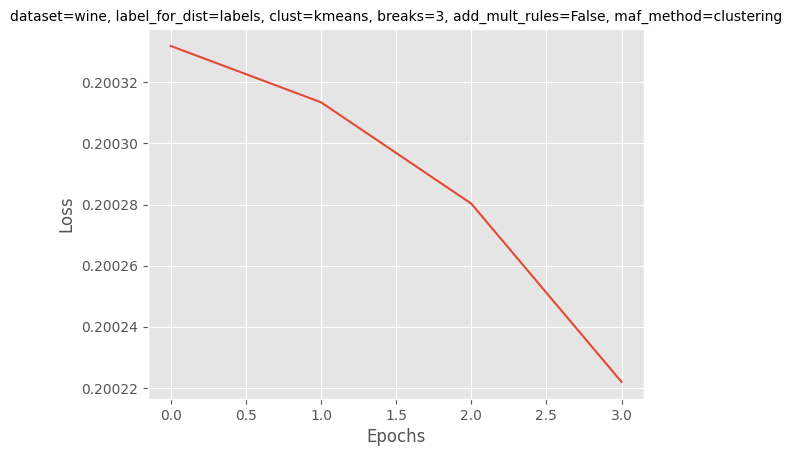

24-04-29 01:48:24 [DEBUG] Accuracy:  0.81
24-04-29 01:48:24 [DEBUG] F1 Score: 0.00
24-04-29 01:48:24 [DEBUG] Confusion Matrix: 
[[1584    0]
 [ 366    0]]
24-04-29 01:48:24 [INFO] ------------------------------
24-04-29 01:48:24 [INFO] Step 5: Run DST (dataset=wine, label_for_dist=labels, clust=kmeans, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:48:24 [DEBUG] 	Model init done


Optimization started
Processing epoch	155	0.0032	

24-04-29 01:53:28 [DEBUG] 	Model fit done



Training time: 304.20s, epochs: 155

Least training loss reached: 0.003
DSModelMultiQ(
  DS Classifier using 50 rules
  
  Rule 1: fixed acidity < 6.338
  	C1: 0.209	C2: 0.006	Unc: 0.785
  
  Rule 2: 6.338 < fixed acidity < 7.220
  	C1: 0.116	C2: 0.062	Unc: 0.821
  
  Rule 3: 7.220 < fixed acidity < 8.102
  	C1: 0.134	C2: 0.049	Unc: 0.817
  
  Rule 4: fixed acidity > 8.102
  	C1: 0.167	C2: 0.016	Unc: 0.817
  
  Rule 5: volatile acidity < 0.230
  	C1: 0.025	C2: 0.174	Unc: 0.801
  
  Rule 6: 0.230 < volatile acidity < 0.341
  	C1: 0.137	C2: 0.046	Unc: 0.817
  
  Rule 7: 0.341 < volatile acidity < 0.452
  	C1: 0.173	C2: 0.009	Unc: 0.818
  
  Rule 8: volatile acidity > 0.452
  	C1: 0.350	C2: 0.000	Unc: 0.650
  
  Rule 9: citric acid < 0.221
  	C1: 0.245	C2: 0.023	Unc: 0.732
  
  Rule 10: 0.221 < citric acid < 0.318
  	C1: 0.128	C2: 0.060	Unc: 0.813
  
  Rule 11: 0.318 < citric acid < 0.416
  	C1: 0.138	C2: 0.047	Unc: 0.815
  
  Rule 12: citric acid > 0.416
  	C1: 0.175	C2: 0.013	Unc: 0.81

24-04-29 01:53:29 [INFO] Step 6: Inference done
24-04-29 01:53:29 [DEBUG] Training Time: 304.20s
24-04-29 01:53:29 [DEBUG] Epochs: 155
24-04-29 01:53:29 [DEBUG] Min Loss: 0.003


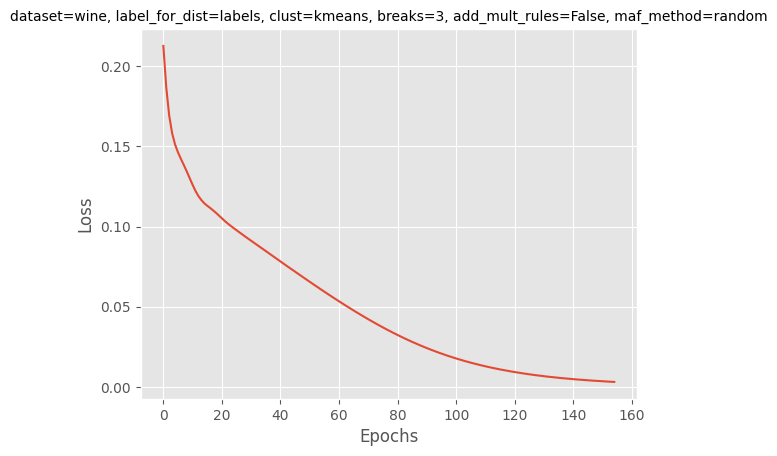

24-04-29 01:53:29 [DEBUG] Accuracy:  1.00
24-04-29 01:53:29 [DEBUG] F1 Score: 1.00
24-04-29 01:53:29 [DEBUG] Confusion Matrix: 
[[1584    0]
 [   0  366]]
24-04-29 01:53:29 [INFO] ------------------------------
24-04-29 01:53:29 [DEBUG] Dataset: wine | Shape: (6497, 14)
24-04-29 01:53:29 [DEBUG] (6497, 14) droped columns with more than 20% missing values
24-04-29 01:53:29 [DEBUG] (6497, 14) drop rows with missing values
24-04-29 01:53:29 [DEBUG] (6497, 14) drop non-numeric columns
24-04-29 01:53:29 [INFO] ------ Dataset: wine | Shape: (6497, 14) | Label ratio: 0.80 -------
24-04-29 01:53:29 [INFO] Step 0: Data split done | 4547 - 1950
24-04-29 01:53:29 [DEBUG] Step 1: Standard scaling complete
24-04-29 01:53:29 [INFO] Step 2.1: Performing dbscan clustering
24-04-29 01:53:35 [INFO] Step 2.1: Clustering and inference done


Found the desired number of clusters: 2 at eps=1.1100000000000005


24-04-29 01:53:35 [DEBUG] Evaluation on train
24-04-29 01:53:35 [DEBUG] 	silhouette = -0.254
24-04-29 01:53:35 [DEBUG] 	calinski_harabasz = 29.99
24-04-29 01:53:35 [DEBUG] Evaluation on test
24-04-29 01:53:35 [DEBUG] 	silhouette = -0.25
24-04-29 01:53:35 [DEBUG] 	calinski_harabasz = 13.012
24-04-29 01:53:35 [INFO] Step 2.2: Clustering evaluation done
24-04-29 01:53:35 [DEBUG] Evaluation on train
24-04-29 01:53:35 [DEBUG] 	Accuracy:  0.78
24-04-29 01:53:35 [DEBUG] 	F1 Score: 0.00
24-04-29 01:53:35 [DEBUG] 	Confusion Matrix: 
[[3540   96]
 [ 911    0]]
24-04-29 01:53:35 [DEBUG] Evaluation on test
24-04-29 01:53:35 [DEBUG] 	Accuracy:  0.79
24-04-29 01:53:35 [DEBUG] 	F1 Score: 0.00
24-04-29 01:53:35 [DEBUG] 	Confusion Matrix: 
[[1541   43]
 [ 366    0]]
24-04-29 01:53:35 [INFO] Step 3: Clustering as a classifier, evaluation done
24-04-29 01:53:37 [INFO] Step 4: Distance calculation done
24-04-29 01:53:37 [DEBUG] Train: 4547
24-04-29 01:53:37 [INFO] Step 5: Run DST (dataset=wine, label_for_

Optimization started
Processing epoch	4	0.2004	

24-04-29 01:53:55 [DEBUG] 	Model fit done



Training time: 9.70s, epochs: 4

Least training loss reached: 0.200
DSModelMultiQ(
  DS Classifier using 50 rules
  
  Rule 1: fixed acidity < 6.338
  	C1: 0.718	C2: 0.141	Unc: 0.140
  
  Rule 2: 6.338 < fixed acidity < 7.220
  	C1: 0.639	C2: 0.181	Unc: 0.180
  
  Rule 3: 7.220 < fixed acidity < 8.102
  	C1: 0.736	C2: 0.132	Unc: 0.132
  
  Rule 4: fixed acidity > 8.102
  	C1: 0.867	C2: 0.067	Unc: 0.066
  
  Rule 5: volatile acidity < 0.230
  	C1: 0.732	C2: 0.134	Unc: 0.134
  
  Rule 6: 0.230 < volatile acidity < 0.341
  	C1: 0.649	C2: 0.176	Unc: 0.175
  
  Rule 7: 0.341 < volatile acidity < 0.452
  	C1: 0.820	C2: 0.090	Unc: 0.090
  
  Rule 8: volatile acidity > 0.452
  	C1: 0.762	C2: 0.120	Unc: 0.118
  
  Rule 9: citric acid < 0.221
  	C1: 0.700	C2: 0.151	Unc: 0.149
  
  Rule 10: 0.221 < citric acid < 0.318
  	C1: 0.691	C2: 0.155	Unc: 0.154
  
  Rule 11: 0.318 < citric acid < 0.416
  	C1: 0.740	C2: 0.130	Unc: 0.130
  
  Rule 12: citric acid > 0.416
  	C1: 0.744	C2: 0.128	Unc: 0.127
  

24-04-29 01:53:55 [INFO] Step 6: Inference done
24-04-29 01:53:55 [DEBUG] Training Time: 9.70s
24-04-29 01:53:55 [DEBUG] Epochs: 4
24-04-29 01:53:55 [DEBUG] Min Loss: 0.200


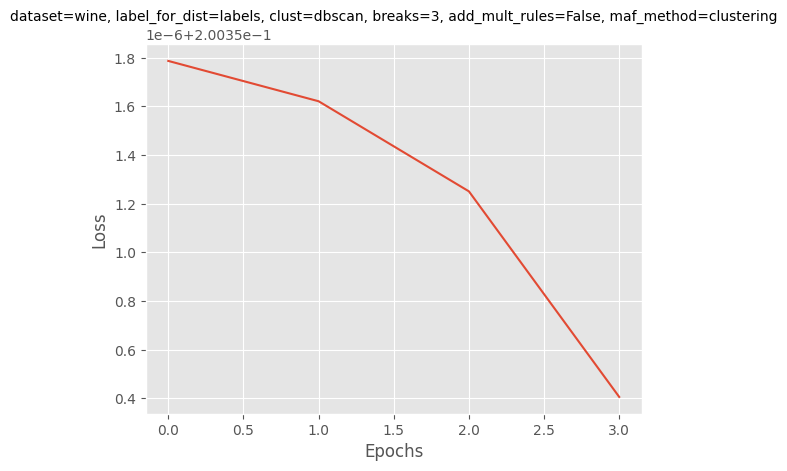

24-04-29 01:53:56 [DEBUG] Accuracy:  0.81
24-04-29 01:53:56 [DEBUG] F1 Score: 0.00
24-04-29 01:53:56 [DEBUG] Confusion Matrix: 
[[1584    0]
 [ 366    0]]
24-04-29 01:53:56 [INFO] ------------------------------
24-04-29 01:53:56 [INFO] Step 5: Run DST (dataset=wine, label_for_dist=labels, clust=dbscan, breaks=3, add_mult_rules=False, maf_method=random)
24-04-29 01:53:56 [DEBUG] 	Model init done


Optimization started
Processing epoch	141	0.0032	

24-04-29 02:00:27 [DEBUG] 	Model fit done



Training time: 390.47s, epochs: 141

Least training loss reached: 0.003
DSModelMultiQ(
  DS Classifier using 50 rules
  
  Rule 1: fixed acidity < 6.338
  	C1: 0.203	C2: 0.000	Unc: 0.797
  
  Rule 2: 6.338 < fixed acidity < 7.220
  	C1: 0.129	C2: 0.057	Unc: 0.814
  
  Rule 3: 7.220 < fixed acidity < 8.102
  	C1: 0.149	C2: 0.040	Unc: 0.812
  
  Rule 4: fixed acidity > 8.102
  	C1: 0.196	C2: 0.008	Unc: 0.796
  
  Rule 5: volatile acidity < 0.230
  	C1: 0.035	C2: 0.139	Unc: 0.825
  
  Rule 6: 0.230 < volatile acidity < 0.341
  	C1: 0.167	C2: 0.029	Unc: 0.804
  
  Rule 7: 0.341 < volatile acidity < 0.452
  	C1: 0.203	C2: 0.000	Unc: 0.797
  
  Rule 8: volatile acidity > 0.452
  	C1: 0.364	C2: 0.000	Unc: 0.636
  
  Rule 9: citric acid < 0.221
  	C1: 0.169	C2: 0.027	Unc: 0.804
  
  Rule 10: 0.221 < citric acid < 0.318
  	C1: 0.066	C2: 0.122	Unc: 0.812
  
  Rule 11: 0.318 < citric acid < 0.416
  	C1: 0.071	C2: 0.104	Unc: 0.825
  
  Rule 12: citric acid > 0.416
  	C1: 0.107	C2: 0.075	Unc: 0.81

24-04-29 02:00:28 [INFO] Step 6: Inference done
24-04-29 02:00:28 [DEBUG] Training Time: 390.47s
24-04-29 02:00:28 [DEBUG] Epochs: 141
24-04-29 02:00:28 [DEBUG] Min Loss: 0.003


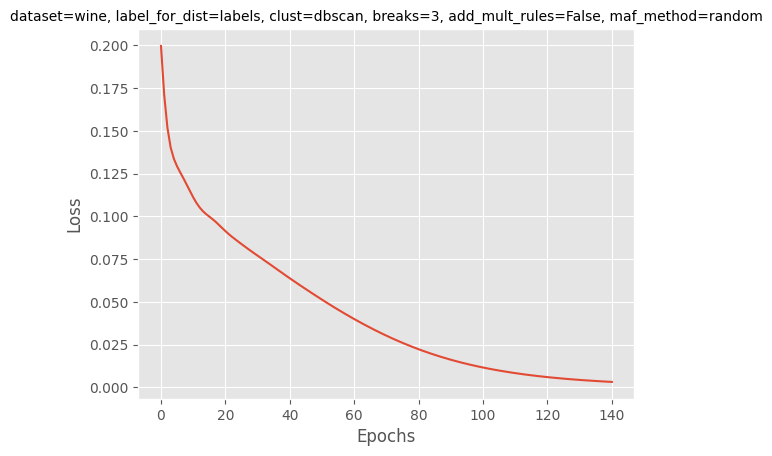

24-04-29 02:00:29 [DEBUG] Accuracy:  1.00
24-04-29 02:00:29 [DEBUG] F1 Score: 1.00
24-04-29 02:00:29 [DEBUG] Confusion Matrix: 
[[1584    0]
 [   0  366]]
24-04-29 02:00:29 [INFO] ------------------------------
100%|██████████| 6/6 [33:15<00:00, 332.56s/it]


In [10]:
from tqdm import tqdm
import traceback

for dataset in tqdm(datasets):
# for dataset in [r"C:\Users\hayk_\OneDrive\Desktop\Thesis\CDSGD\cdsgd\datasets_all\Telecom_customer churn.csv"]:
    # if "wine" in dataset:
    try:
        for cl_alg in ["kmeans", "dbscan"]:
            do_all_for_dataset(dataset, nrows=None, ratio_deviation=0.4, CLUSTERING_ALG=cl_alg)
    except Exception as e:
        logging.info("#"*80)
        logging.error(f"Error for dataset {dataset}: {e}")
        logging.error(traceback.format_exc())
        logging.info("#"*80)
        continue

# Reading the data

## Load the dataset, make checks

In [4]:
dataset = datasets[1]
dataset_name = dataset.split(".")[0]

data = pd.read_csv(os.path.join(DATASET_FOLDER, dataset))#.head(2000)

logger.debug(f"Dataset: {dataset_name} | Shape: {data.shape}")
# if missing more than 20% of the data, drop the column
missing_threshold = 0.2
data = data.dropna(thresh=len(data) * (1 - missing_threshold), axis=1)
logger.debug(f"{data.shape} droped columns with more than {missing_threshold*100:.0f}% missing values")
# drop rows with missing values
data = data.dropna()
logger.debug(f"{data.shape} drop rows with missing values")

assert data.isna().sum().sum() == 0, "Dataset contains missing values"
assert "labels" in data.columns, "Dataset does not contain `labels` column"
assert data.labels.nunique() == 2, "Dataset labels are not binary"

label_ratio = data.labels.value_counts(normalize=True).iloc[0]
assert 0.4 < label_ratio < 0.6, "Label ratio is not balanced"


# leave only numeric columns
data = data.select_dtypes(include=[np.number])
logger.debug(f"{data.shape} drop non-numeric columns")

# move labels column to the end 
data = data[[col for col in data.columns if col != "labels"] + ["labels"]]

logging.info(f"------ Dataset: {dataset_name} | Shape: {data.shape} | Label ratio: {label_ratio:.2f} -------")

24-04-27 21:39:53 [DEBUG] Dataset: Telecom_customer churn | Shape: (100000, 99)
24-04-27 21:39:54 [DEBUG] (100000, 90) droped columns with more than 20% missing values
24-04-27 21:39:55 [DEBUG] (78334, 90) drop rows with missing values
24-04-27 21:39:55 [DEBUG] (78334, 74) drop non-numeric columns
24-04-27 21:39:56 [INFO] ------ Dataset: Telecom_customer churn | Shape: (78334, 74) | Label ratio: 0.52 -------


## Train test split

In [5]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data = data.apply(pd.to_numeric)
cut = int(train_set_size*len(data))

train_data_df = data.iloc[:cut]
test_data_df = data.iloc[cut:]

X_train = data.iloc[:cut, :-1].values
y_train = data.iloc[:cut, -1].values
X_test = data.iloc[cut:, :-1].values
y_test = data.iloc[cut:, -1].values

logging.info(f"Step 0: Data split done | {len(X_train)} - {len(X_test)}")


24-04-27 21:39:56 [INFO] Step 0: Data split done | 54833 - 23501


## Scaling

In [6]:
st_scaler = StandardScaler().fit(train_data_df)
# break
scale = st_scaler.scale_
mean = st_scaler.mean_
var = st_scaler.var_ 

X_train_scaled = st_scaler.transform(train_data_df)
X_test_scaled = st_scaler.transform(test_data_df)  #! during inference we won't have this

logging.debug("Step 1: Standard scaling complete")

24-04-27 21:39:57 [DEBUG] Step 1: Standard scaling complete


## Clustering

### Fitting and Inference

In [8]:

CLUSTERING_ALG = "dbscan" # in future we'll add DBSCAN
# CLUSTERING_ALG = "kmeans" # in future we'll add DBSCAN

logging.info(f"Step 2.1: Performing {CLUSTERING_ALG} clustering")



if CLUSTERING_ALG == "kmeans":
    clustering_model = KMeans(n_clusters=2, random_state=42, n_init="auto")      
    clustering_model.fit(X_train_scaled)  
    
    clustering_labels_train = clustering_model.predict(X_train_scaled)
    clustering_labels_test = clustering_model.predict(X_test_scaled)
else:
    clustering_model = run_dbscan(X_train_scaled, eps=0.01, max_eps=20, min_samples=2, step=0.05) #*X_train.shape[1] - 1)
    if clustering_model is None:
        logging.warning(f"Could not find the desired number of clusters for {dataset_name}")
        raise Exception("Clustering failed")
    
    clustering_labels_train = dbscan_predict(clustering_model, X_train_scaled)
    clustering_labels_test = dbscan_predict(clustering_model, X_test_scaled)
    
    db_eps = clustering_model.eps
    


train_data_df["labels_clustering"] = clustering_labels_train
test_data_df["labels_clustering"] = clustering_labels_test

logger.info(f"Step 2.1: Clustering and inference done")

24-04-27 23:58:02 [INFO] Step 2.1: Performing dbscan clustering


NameError: name 'X_train_scaled' is not defined

## Evaluation (silhouette, ...)

In [ ]:
evaluate_clustering(X_train_scaled, clustering_labels_train, clustering_model, 
                    CLUSTERING_ALG, print_results=True)
evaluate_clustering(X_test_scaled, clustering_labels_test, clustering_model, 
                    CLUSTERING_ALG, print_results=True, dataset="test")

logging.info("Step 2.2: Clustering evaluation done")

24-04-27 20:02:40 [DEBUG] Evaluation on train
24-04-27 20:02:40 [DEBUG] 	silhouette = 0.46
24-04-27 20:02:40 [DEBUG] 	calinski_harabasz = 127.522
24-04-27 20:02:40 [DEBUG] Evaluation on test
24-04-27 20:02:40 [DEBUG] 	silhouette = 0.567
24-04-27 20:02:40 [DEBUG] 	calinski_harabasz = 139.743
24-04-27 20:02:40 [INFO] Step 2.2: Clustering evaluation done


## Clustering evaluation (as pseudo clsassifier)

In [ ]:
evaluate_classifier(y_actual=y_train, y_clust=clustering_labels_train, 
                    dataset="train", print_results=True)
evaluate_classifier(y_actual=y_test, y_clust=clustering_labels_test, 
                    dataset="test", print_results=True)

logger.info("Step 3: Clustering as a classifier, evaluation done")

24-04-27 20:02:40 [DEBUG] Evaluation on train
24-04-27 20:02:40 [DEBUG] 	Accuracy:  0.51
24-04-27 20:02:40 [DEBUG] 	F1 Score: 0.65
24-04-27 20:02:40 [DEBUG] 	Confusion Matrix: 
[[ 66 487]
 [ 38 489]]
24-04-27 20:02:40 [DEBUG] Evaluation on test
24-04-27 20:02:40 [DEBUG] 	Accuracy:  0.51
24-04-27 20:02:40 [DEBUG] 	F1 Score: 0.64
24-04-27 20:02:40 [DEBUG] 	Confusion Matrix: 
[[ 33 213]
 [ 16 201]]
24-04-27 20:02:40 [INFO] Step 3: Clustering as a classifier, evaluation done


## Distance calculation

In [ ]:
db_eps

7.95999999999998

In [ ]:
train_data_df["distance"] = get_distance(X_train_scaled, clustering_model, CLUSTERING_ALG, density_radius=db_eps)
test_data_df["distance"] = get_distance(X_test_scaled, clustering_model, CLUSTERING_ALG, density_radius=db_eps)

In [ ]:
train_data_df["distance_norm"] = remove_outliers_and_normalize(train_data_df, label_column="labels_clustering") 
test_data_df["distance_norm"] = remove_outliers_and_normalize(test_data_df, label_column="labels_clustering")

assert train_data_df.isna().sum().sum() == 0, "Train data contains NaNs"
assert test_data_df.isna().sum().sum() == 0, "Train data contains NaNs"

logger.info(f"Step 4: Distance calculation done")

24-04-27 20:02:41 [INFO] Step 4: Distance calculation done


## DST

In [ ]:
# !pip install -U kaleido
print(1)

1


24-04-27 20:03:06 [DEBUG] Train: 1080
24-04-27 20:03:06 [INFO] Step 5: Run DST (dataset=Telecom_customer churn, clust=dbscan breaks=3, add_mult_rules=False, maf_method=clustering)
24-04-27 20:03:06 [DEBUG] 	Model init done


Optimization started
Processing epoch	9	0.3493	

24-04-27 20:03:25 [DEBUG] 	Model fit done



Training time: 4.52s, epochs: 9

Least training loss reached: 0.352
DSModelMultiQ(
  DS Classifier using 302 rules
  
  Rule 1: rev_Mean < 32.278
  	C1: 0.191	C2: 0.571	Unc: 0.238
  
  Rule 2: 32.278 < rev_Mean < 67.108
  	C1: 0.570	C2: 0.233	Unc: 0.197
  
  Rule 3: 67.108 < rev_Mean < 101.937
  	C1: 0.745	C2: 0.116	Unc: 0.139
  
  Rule 4: rev_Mean > 101.937
  	C1: 0.934	C2: 0.020	Unc: 0.046
  
  Rule 5: mou_Mean < 137.502
  	C1: 0.194	C2: 0.563	Unc: 0.243
  
  Rule 6: 137.502 < mou_Mean < 588.828
  	C1: 0.157	C2: 0.606	Unc: 0.237
  
  Rule 7: 588.828 < mou_Mean < 1040.153
  	C1: 0.725	C2: 0.116	Unc: 0.159
  
  Rule 8: mou_Mean > 1040.153
  	C1: 0.949	C2: 0.014	Unc: 0.037
  
  Rule 9: totmrc_Mean < 29.970
  	C1: 0.181	C2: 0.569	Unc: 0.250
  
  Rule 10: 29.970 < totmrc_Mean < 51.264
  	C1: 0.151	C2: 0.655	Unc: 0.194
  
  Rule 11: 51.264 < totmrc_Mean < 72.558
  	C1: 0.674	C2: 0.184	Unc: 0.143
  
  Rule 12: totmrc_Mean > 72.558
  	C1: 0.870	C2: 0.055	Unc: 0.075
  
  Rule 13: da_Mean < -

24-04-27 20:03:26 [INFO] Step 6: Inference done
24-04-27 20:03:26 [DEBUG] Training Time: 4.52s
24-04-27 20:03:26 [DEBUG] Epochs: 9
24-04-27 20:03:26 [DEBUG] Min Loss: 0.352
24-04-27 20:03:26 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
24-04-27 20:03:26 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.


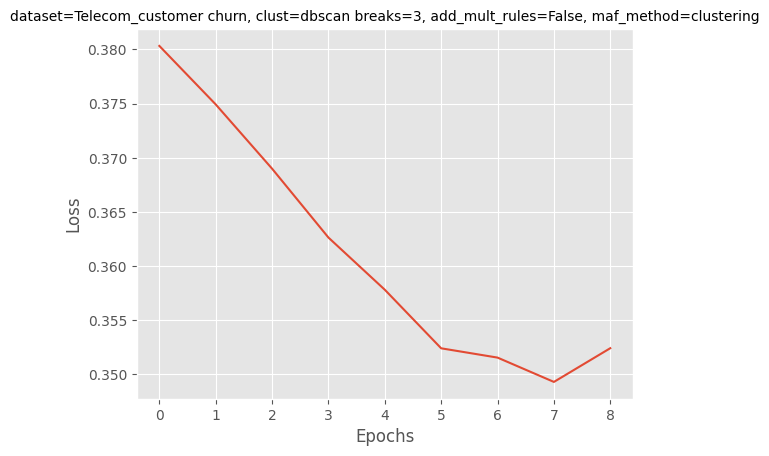

24-04-27 20:03:26 [DEBUG] Accuracy:  0.57
24-04-27 20:03:26 [DEBUG] F1 Score: 0.37
24-04-27 20:03:26 [DEBUG] Confusion Matrix: 
[[204  42]
 [159  58]]
24-04-27 20:03:26 [INFO] ------------------------------
24-04-27 20:03:26 [INFO] Step 5: Run DST (dataset=Telecom_customer churn, clust=dbscan breaks=3, add_mult_rules=False, maf_method=random)
24-04-27 20:03:26 [DEBUG] 	Model init done


Optimization started
Processing epoch	127	0.1849	

24-04-27 20:04:28 [DEBUG] 	Model fit done



Training time: 61.70s, epochs: 127

Least training loss reached: 0.185
DSModelMultiQ(
  DS Classifier using 302 rules
  
  Rule 1: rev_Mean < 32.278
  	C1: 0.139	C2: 0.045	Unc: 0.816
  
  Rule 2: 32.278 < rev_Mean < 67.108
  	C1: 0.056	C2: 0.138	Unc: 0.806
  
  Rule 3: 67.108 < rev_Mean < 101.937
  	C1: 0.171	C2: 0.020	Unc: 0.809
  
  Rule 4: rev_Mean > 101.937
  	C1: 0.000	C2: 0.234	Unc: 0.766
  
  Rule 5: mou_Mean < 137.502
  	C1: 0.000	C2: 0.210	Unc: 0.790
  
  Rule 6: 137.502 < mou_Mean < 588.828
  	C1: 0.000	C2: 0.235	Unc: 0.765
  
  Rule 7: 588.828 < mou_Mean < 1040.153
  	C1: 0.380	C2: 0.000	Unc: 0.620
  
  Rule 8: mou_Mean > 1040.153
  	C1: 0.361	C2: 0.000	Unc: 0.639
  
  Rule 9: totmrc_Mean < 29.970
  	C1: 0.000	C2: 0.271	Unc: 0.729
  
  Rule 10: 29.970 < totmrc_Mean < 51.264
  	C1: 0.014	C2: 0.179	Unc: 0.807
  
  Rule 11: 51.264 < totmrc_Mean < 72.558
  	C1: 0.025	C2: 0.159	Unc: 0.816
  
  Rule 12: totmrc_Mean > 72.558
  	C1: 0.340	C2: 0.000	Unc: 0.660
  
  Rule 13: da_Mean 

24-04-27 20:04:29 [INFO] Step 6: Inference done
24-04-27 20:04:29 [DEBUG] Training Time: 61.70s
24-04-27 20:04:29 [DEBUG] Epochs: 127
24-04-27 20:04:29 [DEBUG] Min Loss: 0.185


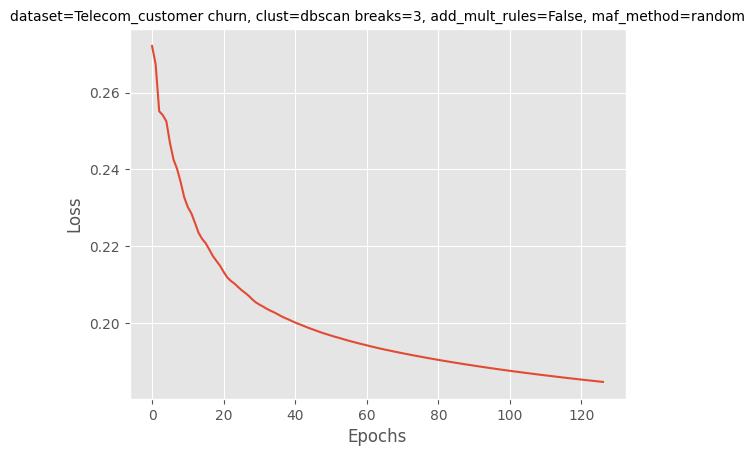

24-04-27 20:04:29 [DEBUG] Accuracy:  0.61
24-04-27 20:04:29 [DEBUG] F1 Score: 0.59
24-04-27 20:04:29 [DEBUG] Confusion Matrix: 
[[150  96]
 [ 85 132]]
24-04-27 20:04:29 [INFO] ------------------------------


In [ ]:
num_breaks = 3
mult_rules = False
debug_mode = True
print_final_model = True
num_workers = 0

RULE_FOLDER = "rules_saved_clean"

ignore_for_training = ["labels_clustering", "distance_norm"]
df_cols = [i for i in list(data.columns) if i not in ignore_for_training]

rows_use = None
if rows_use:
    train_data_df_use = train_data_df.head(rows_use)
    X_train_use = X_train[:rows_use]
    y_train_use = y_train[:rows_use]
else:
    train_data_df_use = train_data_df
    X_train_use = X_train
    y_train_use = y_train
logger.debug(f"Train: {len(X_train_use)}")
for method in ["clustering", "random"]:
    name = f"dataset={dataset_name}, clust={CLUSTERING_ALG} breaks={num_breaks}, add_mult_rules={mult_rules}, maf_method={method}"
    logger.info(f"Step 5: Run DST ({name})")
    DSC = DSClassifierMultiQ(2, debug_mode=debug_mode, num_workers=num_workers, maf_method=method,
                            data=train_data_df_use, precompute_rules=True, )#.head(rows_use))
    logger.debug(f"\tModel init done")    
    res = DSC.fit(X_train_use, y_train_use, 
            add_single_rules=True, single_rules_breaks=num_breaks, add_mult_rules=mult_rules,
            column_names=df_cols, print_every_epochs=1, print_final_model=print_final_model)
    losses, epoch, dt = res
    logger.debug(f"\tModel fit done")

    DSC.model.save_rules_bin(os.path.join(RULE_FOLDER, f"{name}.dsb"))
#     most_important_rules = DSC.model.find_most_important_rules()
#     print(most_important_rules)
    DSC.model.print_most_important_rules()
    y_pred = DSC.predict(X_test)

    logger.info(f"Step 6: Inference done")

    report_results(y_test, y_pred, dataset=dataset_name, method=method,
                epoch=epoch, dt=dt, losses=losses, 
                save_results=True, name=name, print_results=True,
                breaks=num_breaks, mult_rules=mult_rules, )
    
    logging.info("-"*30)
    
    

In [ ]:
filter_by_rule(train_data_df_use, lambda x: x["rev_Mean"] < 32.278, print_results=True)

24-04-27 19:58:28 [DEBUG] Number of data points left after filtering: 262
24-04-27 19:58:28 [DEBUG] Number of clusters left after filtering: 2
24-04-27 19:58:28 [DEBUG] Most common cluster: 1
24-04-27 19:58:28 [DEBUG] Data points belong to different clusters
24-04-27 19:58:28 [DEBUG] Confidence: 0.21651189312479646
24-04-27 19:58:28 [DEBUG] Confidence after lowering based on proportion: 0.5364860436425323


(0.2317569781787339, 0.5364860436425323, 0.2317569781787339)

AttributeError: 'Axes' object has no attribute 'isna'

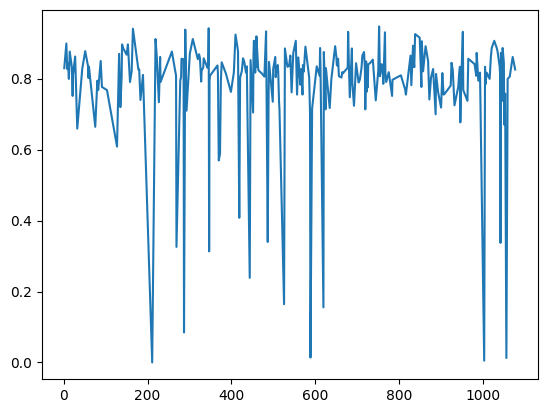

In [ ]:
train_data_df_use.query("rev_Mean < 32.278").distance_norm.plot().isna().sum()

In [ ]:
experiments = pd.read_csv("experiments.csv")

experiments.tail(2)

,name,accuracy,f1,confusion_matrix,training_time,epochs,min_loss,datetime,MAF method,dataset,breaks,mult_rules
84,"dataset=Brain Tumor, breaks=3, add_mult_rules=...",0.975199,0.970833,[[635 9]\n [ 19 466]],288.094734,69,0.033078,26-04-2024 21:24:14,kmeans,Brain Tumor,3.0,False
85,"dataset=Brain Tumor, breaks=3, add_mult_rules=...",0.982285,0.979339,[[635 9]\n [ 11 474]],394.811531,137,0.026403,26-04-2024 21:30:50,random,Brain Tumor,3.0,False


## Rules

In [34]:
RULE_FOLDER = "rules_saved_clean"

assert os.path.exists(RULE_FOLDER), f"Folder {RULE_FOLDER} does not exist"

rules = os.listdir(RULE_FOLDER)
logging.info(f"Found {len(rules)} rules")

24-04-26 21:41:45 [INFO] Found 4 rules


In [35]:
def get_pairs(rules):
    pairs = []
    for rule1 in rules:
        if 'maf_method' in rule1:
            for rule2 in rules:
                if rule1 == rule2 or (rule2, rule1) in pairs:
                    continue
                if rule2.startswith(rule1.split('maf_method')[0]):
                    pairs.append((rule1, rule2))
    return pairs

In [36]:
def extract_res(rules_info):
    rules = rules_info["preds"]
    mafs = rules_info["masses"]
    
    rule_names = [str(i) for i in rules]
    mass_first = [float(i[0]) for i in mafs]
    mass_second = [float(i[1]) for i in mafs]
    uncertainty = [float(i[2]) for i in mafs]
    
    res = {"rule": rule_names, "mass_first": mass_first, "mass_second": mass_second, "uncertainty": uncertainty}
    return res

In [39]:
pairs = get_pairs(rules)

dfs = {}

for r1, r2 in pairs:
    r1_info = pickle.load(open(os.path.join(RULE_FOLDER, r1), "rb"))
    r2_info = pickle.load(open(os.path.join(RULE_FOLDER, r2), "rb"))
    
    r1_df = pd.DataFrame(extract_res(r1_info))
    r2_df = pd.DataFrame(extract_res(r2_info))
    
    
    merged = pd.merge(r1_df, r2_df, on="rule", suffixes=('_kmeans', '_random'))
    merged.to_csv(f"rules_{r1}_{r2}.csv", index=False)

    print(f"Num rules {len(merged)}")
    fig = px.bar(merged, x='rule', y=['uncertainty_kmeans', 'uncertainty_random'], 
        title='Uncertainty comparison between kmeans and random', # put bars next to each other
        barmode='group')
    fig.write_html(f"{r1}_{r2}.html")
    dfs[r1] = merged 
    fig.show()

Num rules 49


Num rules 205


In [55]:
ks = list(dfs.keys())
print(ks)
a = dfs[ks[1]]


a["Uncertainty ratio"]  = a["uncertainty_random"] / a["uncertainty_kmeans"]

# remove inf
res = a["Uncertainty ratio"] 
res.replace([np.inf, -np.inf, ""], np.nan, inplace=True)

res = a["Uncertainty ratio"].dropna()

res.describe().round(3).to_clipboard()

['dataset=Brain Tumor, breaks=3, add_mult_rules=False, maf_method=kmeans.dsb', 'dataset=Brain Tumor, breaks=3, add_mult_rules=True, maf_method=kmeans.dsb']


In [47]:
a["Uncertainty ratio"].dropna()

0      1.950997
1      2.039998
2      2.296427
3      5.962318
4      2.055425
5      2.271974
6      2.257644
7      2.475599
8      2.068167
9      2.035401
10     2.328404
11     2.335880
12          inf
13     2.287148
14     1.489149
15     1.555324
16     1.407726
17     2.373192
18     2.151206
19     1.607796
20     0.800000
21     2.002392
22     2.090169
23     1.189022
24     2.078127
25     2.271453
26    11.785043
27     2.108319
28          inf
29    81.841992
30     1.546927
31     1.712679
32          inf
33     2.370462
34     1.966143
35     1.921688
36          inf
37     1.557658
38     1.915628
39     1.645202
40     2.094582
41     2.243877
42     2.615344
43     1.885207
44     2.361644
45     2.370196
46     1.955638
47     2.339852
48     5.545559
Name: Uncertainty ratio, dtype: float64

In [31]:

print(f"Num rules {len(merged)}")

Num rules 205


In [71]:
px.bar(merged, x='rule', y=['uncertainty_kmeans', 'uncertainty_random'], 
       title='Uncertainty comparison between kmeans and random', # put bars next to each other
       barmode='group')

# Misc

In [25]:
df_  = pd.read_csv(r"datasets\breast-cancer-wisconsin.csv")
df_["labels"] = df_["labels"].replace({2: 0, 4: 1})
df_.to_csv(r"datasets\breast-cancer-wisconsin.csv", index=False)